In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore
#import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_columns', 60)
%matplotlib inline

In [2]:
#import data from cvs files:

primary_results = pd.read_csv('/Users/saraszczepanski/Documents/python_work/2016-us-election/primary_results.csv')
county_facts = pd.read_csv('/Users/saraszczepanski/Documents/python_work/2016-us-election/county_facts.csv')
county_facts_dict = pd.read_csv('/Users/saraszczepanski/Documents/python_work/2016-us-election/county_facts_dictionary.csv')


In [3]:
primary_results['state'].unique()
#Note: missing DC, Minnesota

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [4]:
primary_results.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,1001.0,Democrat,Bernie Sanders,544,0.182
1,Alabama,AL,Autauga,1001.0,Democrat,Hillary Clinton,2387,0.800
2,Alabama,AL,Baldwin,1003.0,Democrat,Bernie Sanders,2694,0.329
3,Alabama,AL,Baldwin,1003.0,Democrat,Hillary Clinton,5290,0.647
4,Alabama,AL,Barbour,1005.0,Democrat,Bernie Sanders,222,0.078


In [5]:
# ANALYSIS of STATE DATA FIRST:

#note that there are no totals per state included in primary_results, unlike the county facts data.
#so we will have to do all of the aggregating for primary_results. 

#calculate total number of votes per state, per democratic or republican candidate:
#totals_by_state_party_candidate = primary_results.groupby(['state','party','candidate'],as_index=False).votes.sum()
totals_by_state_party_candidate = primary_results.groupby(['state','party','candidate']).votes.sum()

In [6]:
totals_by_state_party_candidate

state          party       candidate      
Alabama        Democrat    Bernie Sanders       76399
                           Hillary Clinton     309928
               Republican  Ben Carson           87517
                           Donald Trump        371735
                           John Kasich          37970
                           Marco Rubio         159802
                           Ted Cruz            180608
Alaska         Democrat    Bernie Sanders         440
                           Hillary Clinton         99
               Republican  Ben Carson            2401
                           Donald Trump          7346
                           John Kasich            892
                           Marco Rubio           3318
                           Ted Cruz              7973
Arizona        Democrat    Bernie Sanders      163400
                           Hillary Clinton     235697
               Republican  Donald Trump        249916
                           John Kasich 

In [7]:
#totals_by_state_party = primary_results.groupby(['state','party'],as_index=False).votes.sum()
totals_by_state_party = primary_results.groupby(['state','party']).votes.sum()
totals_by_state_party

state           party     
Alabama         Democrat       386327
                Republican     837632
Alaska          Democrat          539
                Republican      21930
Arizona         Democrat       399097
                Republican     435103
Arkansas        Democrat       209448
                Republican     396523
California      Democrat      3442623
                Republican    1495574
Colorado        Democrat       121184
Connecticut     Democrat       322485
                Republican     208817
Delaware        Democrat        92609
                Republican      67807
Florida         Democrat      1664003
                Republican    2276926
Georgia         Democrat       757340
                Republican    1275601
Hawaii          Democrat        33658
                Republican      13228
Idaho           Democrat        23705
                Republican     215284
Illinois        Democrat      1987834
                Republican    1384703
Indiana         Democra

In [8]:
# Next, we want to calculate the proportion of the vote that each candidate received. 

# NOTE: the code below doesn't work!! (even though it should)... it throws the following error:
# NotImplementedError: merging with more than one level overlap on a multi-index is not implemented
# apparently pandas will not let you do a partial divide across two muli-indexes. 
# Need to figure out a work around for this.
# totals_by_state_party_candidate['proportion_votes'] = totals_by_state_party_candidate.div(totals_by_state_party)

In [9]:
# the solution to the above problem is to unstack the column that is not joined during the
# division (in this case, 'candidate') and to then restack it after the division has occurred.
proportion_of_vote = totals_by_state_party_candidate.unstack('candidate').div(totals_by_state_party, axis=0).stack('candidate')

In [10]:
#reset index 
totals_by_state_party_candidate = totals_by_state_party_candidate.reset_index()
proportion_of_vote = proportion_of_vote.reset_index()

In [11]:
#assign values from proportion_of_vote to the last column of totals_by_state_party_candidate
totals_by_state_party_candidate['proportion_of_vote'] = proportion_of_vote.ix[:,3]

In [12]:
totals_by_state_party_candidate.head(20)

,state,party,candidate,votes,proportion_of_vote
0,Alabama,Democrat,Bernie Sanders,76399,0.197757
1,Alabama,Democrat,Hillary Clinton,309928,0.802243
2,Alabama,Republican,Ben Carson,87517,0.104481
3,Alabama,Republican,Donald Trump,371735,0.443793
4,Alabama,Republican,John Kasich,37970,0.045330
5,Alabama,Republican,Marco Rubio,159802,0.190778
6,Alabama,Republican,Ted Cruz,180608,0.215617
7,Alaska,Democrat,Bernie Sanders,440,0.816327
8,Alaska,Democrat,Hillary Clinton,99,0.183673
9,Alaska,Republican,Ben Carson,2401,0.109485


In [13]:
#create variables that describe proportion of votes for a candidate:
all_candidates_prop_vote_per_state = totals_by_state_party_candidate[['state','candidate','proportion_of_vote']].set_index('candidate')

#Democrat candidates:
#Hillary Clinton- 49 states, missing Minn
Clinton_prop_vote_per_state = all_candidates_prop_vote_per_state.loc['Hillary Clinton']
#Bernie Sanders- 49 states, missing Minn
Sanders_prop_vote_per_state = all_candidates_prop_vote_per_state.loc['Bernie Sanders']

#Republican candidates: note that I am not analyzing Ben Carson & others, 
#since many dropped out of the race early. 
#Donald Trump- 46 states, missing Colorado, Maine, Minn, North Dakota
Trump_prop_vote_per_state = all_candidates_prop_vote_per_state.loc['Donald Trump']
#Ted Cruz- 46 states, missing Colorado, Maine, Minn, North Dakota 
Cruz_prop_vote_per_state = all_candidates_prop_vote_per_state.loc['Ted Cruz']
#John Kasich- 46 states, missing Colorado, Maine, Minn, North Dakota 
Kasich_prop_vote_per_state = all_candidates_prop_vote_per_state.loc['John Kasich']
#Marco Rubio- 27 states, dropped out early
Rubio_prop_vote_per_state = all_candidates_prop_vote_per_state.loc['Marco Rubio']

In [14]:
Clinton_prop_vote_per_state.head

<bound method NDFrame.head of                           state  proportion_of_vote
candidate                                          
Hillary Clinton         Alabama            0.802243
Hillary Clinton          Alaska            0.183673
Hillary Clinton         Arizona            0.590576
Hillary Clinton        Arkansas            0.690291
Hillary Clinton      California            0.563692
Hillary Clinton        Colorado            0.406456
Hillary Clinton     Connecticut            0.527389
Hillary Clinton        Delaware            0.604153
Hillary Clinton         Florida            0.659494
Hillary Clinton         Georgia            0.716994
Hillary Clinton          Hawaii            0.300879
Hillary Clinton           Idaho            0.213668
Hillary Clinton        Illinois            0.509185
Hillary Clinton         Indiana            0.475045
Hillary Clinton            Iowa            0.498164
Hillary Clinton          Kansas            0.322542
Hillary Clinton        Kentucky   

In [15]:
#county_facts data:
county_facts.head(10)

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,0,United States,NaN,318857056,308758105,3.3,308745538,6.2,23.1,14.5,50.8,77.4,13.2,1.2,5.4,0.2,2.5,17.4,62.1,84.9,12.9,20.7,86.0,28.8,21263779,25.5,133957180,64.9,26.0,176700,115610216,2.63,28155,53046,15.4,7488353,118266253,2.0,23005620,27092908,7.1,0.9,5.7,0.1,8.3,28.8,5319456312,4174286516,3917663456,12990,613795732,1046363,3531905.43,87.4
1,1000,Alabama,NaN,4849377,4780127,1.4,4779736,6.1,22.8,15.3,51.5,69.7,26.7,0.7,1.3,0.1,1.5,4.1,66.2,85.0,3.5,5.2,83.1,22.6,388865,24.2,2207912,69.7,15.9,122500,1838683,2.55,23680,43253,18.6,97578,1603100,1.1,311578,382350,14.8,0.8,1.8,0.1,1.2,28.1,112858843,52252752,57344851,12364,6426342,13369,50645.33,94.4
2,1001,Autauga County,AL,55395,54571,1.5,54571,6.0,25.2,13.8,51.4,77.9,18.7,0.5,1.1,0.1,1.8,2.7,75.6,85.0,1.6,3.5,85.6,20.9,5922,26.2,22751,76.8,8.3,136200,20071,2.71,24571,53682,12.1,817,10120,2.1,2947,4067,15.2,0.0,1.3,0.0,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
3,1003,Baldwin County,AL,200111,182265,9.8,182265,5.6,22.2,18.7,51.2,87.1,9.6,0.7,0.9,0.1,1.6,4.6,83.0,82.1,3.6,5.5,89.1,27.7,19346,25.9,107374,72.6,24.4,168600,73283,2.52,26766,50221,13.9,4871,54988,3.7,16508,19035,2.7,0.4,1.0,0.0,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
4,1005,Barbour County,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,46.6,50.2,47.6,0.6,0.5,0.2,0.9,4.5,46.6,84.8,2.9,5.0,73.7,13.4,2120,24.6,11799,67.7,10.6,89200,9200,2.66,16829,32911,26.7,464,6611,-5.6,1546,1667,0.0,0.0,0.0,0.0,0.0,27.0,0,0,188337,6334,0,8,884.88,31.0
5,1007,Bibb County,AL,22506,22919,-1.8,22915,5.3,21.0,14.8,45.9,76.3,22.1,0.4,0.2,0.1,0.9,2.1,74.5,86.6,1.2,2.1,77.5,12.1,1327,27.6,8978,79.0,7.3,90500,7091,3.03,17427,36447,18.1,275,3145,7.5,1126,1385,14.9,0.0,0.0,0.0,0.0,0.0,0,0,124707,5804,10757,19,622.58,36.8
6,1009,Blount County,AL,57719,57322,0.7,57322,6.1,23.6,17.0,50.5,96.0,1.8,0.6,0.3,0.1,1.2,8.7,87.8,88.7,4.3,7.3,77.0,12.1,4540,33.9,23826,81.0,4.5,117100,21108,2.70,20730,44145,15.8,660,6798,3.4,3563,4458,0.0,0.0,0.0,0.0,0.0,23.2,341544,0,319700,5622,20941,3,644.78,88.9
7,1011,Bullock County,AL,10764,10915,-1.4,10914,6.3,21.4,14.9,45.3,26.9,70.1,0.8,0.3,0.7,1.1,7.5,22.1,84.7,5.4,5.2,67.8,12.5,636,26.9,4461,74.3,8.7,70600,3741,2.73,18628,32033,21.6,112,0,0.0,470,417,0.0,0.0,0.0,0.0,0.0,38.8,0,0,43810,3995,3670,1,622.81,17.5
8,1013,Butler County,AL,20296,20946,-3.1,20947,6.1,23.6,18.0,53.6,53.9,44.0,0.4,0.9,0.0,0.8,1.2,53.1,94.6,0.8,1.7,76.3,14.0,1497,24.0,9916,70.3,13.3,74700,8235,2.47,17403,29918,28.4,393,5711,2.7,1095,1769,0.0,0.0,3.3,0.0,0.0,0.0,399132,56712,229277,11326,28427,2,776.83,27.0
9,1015,Calhoun County,AL,115916,118586,-2.3,118572,5.7,22.2,16.0,51.8,75.8,21.1,0.5,0.9,0.1,1.7,3.5,72.9,83.6,2.4,4.5,78.6,16.1,11385,22.5,53289,68.7,13.8,100600,45196,2.54,20828,39962,21.9,2311,34871,0.6,6352,8713,7.2,0.0,1.6,0.0,0.5,24.7,2679991,0,1542981,13678,186533,114,605.87,195.7


In [16]:
#set up index in order to investigate state-level numbers: 
all_states_index = county_facts['area_name'].str.contains('County|Area|city|Borough|Parish|City|Municipality|United|District|Minnesota') == False

all_states = county_facts['area_name'][all_states_index]#note: we had to delete DC & Minnesota entries, 
# since primary_results do not contain these. 
all_states

1              Alabama
69              Alaska
99             Arizona
115           Arkansas
191         California
250           Colorado
315        Connecticut
324           Delaware
330            Florida
398            Georgia
558             Hawaii
564              Idaho
609           Illinois
712            Indiana
805               Iowa
905             Kansas
1011          Kentucky
1132         Louisiana
1197             Maine
1214          Maryland
1239     Massachusetts
1254          Michigan
1426       Mississippi
1509          Missouri
1625           Montana
1682          Nebraska
1776            Nevada
1794     New Hampshire
1805        New Jersey
1827        New Mexico
1861          New York
1924    North Carolina
2025      North Dakota
2079              Ohio
2168          Oklahoma
2246            Oregon
2283      Pennsylvania
2351      Rhode Island
2357    South Carolina
2404      South Dakota
2471         Tennessee
2567             Texas
2822              Utah
2852       

In [17]:
# Next, we want to isolate the variables in county_facts we are interested in analyzing further:
#
# Variables that we are intested in analyzing further:
#% of population that is over 65 (seniors)
#% women in state (do women have a voting preference?)
#% of households that have two or more races 
#% african american-- note only have % african american, no mixed race
#% hispanic
#% foreign born 
#% college grad
# median household income or % below poverty?
#% persons in private nonfarm employment- employment rate-- need to calculate this.
#% veterans by state-- need to calculate this.


In [18]:
# Create new column: % veterans- total number of veterans / population, 2014
county_facts['percent_veterans'] = county_facts.VET605213 / county_facts.PST045214 * 100

In [19]:
# Creat new column: % persons in private nonfarm employment- 
# total persons in private nonfarm employ/population, 2014
county_facts['percent_priv_nonfarm_employ'] = county_facts.BZA110213 / county_facts.PST045214 *100

In [20]:
# Analyze results on STATE level first:

#Isolate columns of county_facts that we would like to analyze more:
county_facts_of_interest = county_facts[['AGE775214','SEX255214','RHI625214','RHI225214', 
                                       'RHI725214','POP645213', 'EDU685213','INC110213',
                                        'PVY020213','percent_veterans',
                                        'percent_priv_nonfarm_employ']][all_states_index]
#set states as index:
county_facts_of_interest.index = all_states
#rename columns for ease of reading:
new_column_names ={'AGE775214': 'percent_over65','SEX255214': 'percent_women',
                  'RHI625214': 'percent_two_races','RHI225214': 'percent_black',
                  'RHI725214': 'percent_hispanic', 'POP645213': 'percent_foreign_born',
                  'EDU685213': 'percent_college_grad','INC110213': 'med_household_income',
                  'PVY020213': 'percent_below_poverty'}
county_facts_of_interest = county_facts_of_interest.rename(columns=new_column_names)

In [21]:
county_facts_of_interest

,percent_over65,percent_women,percent_two_races,percent_black,percent_hispanic,percent_foreign_born,percent_college_grad,med_household_income,percent_below_poverty,percent_veterans,percent_priv_nonfarm_employ
area_name,,,,,,,,,,,
Alabama,15.3,51.5,1.5,26.7,4.1,3.5,22.6,43253,18.6,8.018865,33.057855
Alaska,9.4,47.4,7.1,3.9,6.8,7.0,27.5,70760,9.9,9.637697,36.190501
Arizona,15.9,50.3,2.7,4.7,30.5,13.4,26.9,49774,17.9,7.760280,32.284189
Arkansas,15.7,50.9,1.9,15.6,7.0,4.5,20.1,40768,19.2,8.000050,32.972769
California,12.9,50.3,3.7,6.5,38.6,27.0,30.7,61094,15.9,4.879941,34.538659
Colorado,12.7,49.8,2.9,4.5,21.2,9.7,37.0,58433,13.2,7.458327,39.040839
Connecticut,15.5,51.2,2.2,11.5,15.0,13.6,36.5,69461,10.2,6.059677,40.971291
Delaware,16.4,51.6,2.5,22.2,8.9,8.4,28.9,59878,11.7,8.024784,40.842484
Florida,19.1,51.1,2.0,16.8,24.1,19.4,26.4,46956,16.3,7.889120,35.864563


In [22]:
#run some pearson correlations between some factors and the support for each candidate:
# For Hilary Clinton:
Clinton_correlations_state = []
for column in range(0,county_facts_of_interest.columns.size):
    r, p_value = scipy.stats.pearsonr(Clinton_prop_vote_per_state.proportion_of_vote,county_facts_of_interest[county_facts_of_interest.columns[column]])
    Clinton_correlations_state.append([county_facts_of_interest.columns[column],r,p_value])

In [23]:
Clinton_correlations_state

[['percent_over65', 0.11409367272928778, 0.43504238405973217],
 ['percent_women', 0.64388958389095419, 6.001585648691237e-07],
 ['percent_two_races', -0.29856094335909306, 0.037181764435970294],
 ['percent_black', 0.81456470229707745, 1.0763194602919493e-12],
 ['percent_hispanic', 0.11633955444301508, 0.42599592788042751],
 ['percent_foreign_born', 0.12027444009162314, 0.41040503304870246],
 ['percent_college_grad', -0.25139813996420596, 0.081427422299897523],
 ['med_household_income', -0.2831568862849449, 0.048668546901795166],
 ['percent_below_poverty', 0.5228626985242385, 0.00011608152870637844],
 ['percent_veterans', -0.20122853799656079, 0.16560474326431512],
 ['percent_priv_nonfarm_employ', -0.27825666672973831, 0.052875369333592763]]

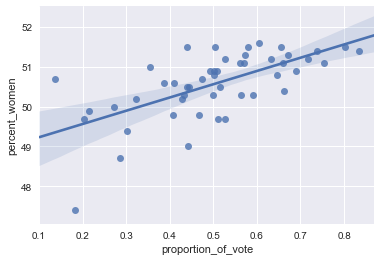

In [24]:
# Looks like percent_women, percent_two_races, percent_black, median household income, 
# & percent_below_poverty all correlate with the proporiton of votes Clinton received.
# Let's look at what these correlations looks like across states:

# Proportion of vote for Clinton vs. % of women in state.
# Higher % of women, more votes for Clinton:
g = sns.regplot(Clinton_prop_vote_per_state.proportion_of_vote,county_facts_of_interest.percent_women)

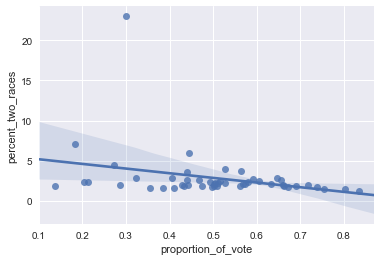

In [25]:
# Proportion of vote for Clinton vs. % of households with 2 races or more:
# Looks like Clinton got less votes in states with a higher prop of 
# households with 2 races or more (but could be affected by outlier--Hawaii)
g = sns.regplot(Clinton_prop_vote_per_state.proportion_of_vote,county_facts_of_interest.percent_two_races)

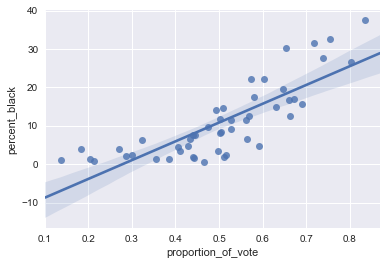

In [26]:
# Proportion of vote for Clinton vs. % african american population per state:
# Higher % african americans, higher percentage of votes for Clinton:
g = sns.regplot(Clinton_prop_vote_per_state.proportion_of_vote,county_facts_of_interest.percent_black)

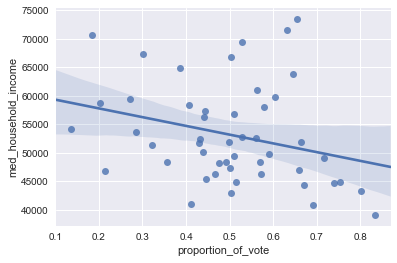

In [27]:
# Proportion of vote for Clinton vs. median household income per state:
# States was higher median household incomes gave Clinton less proportion of vote,
# although this correlation is not strong: 
g = sns.regplot(Clinton_prop_vote_per_state.proportion_of_vote,county_facts_of_interest.med_household_income)

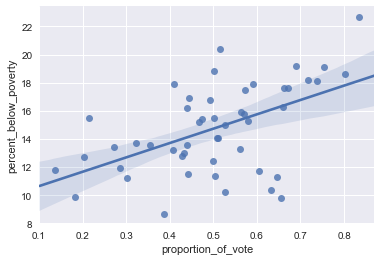

In [28]:
# Proportion of vote for Clinton vs. % below poverty per state:
# States with higher poverty levels were more likely to vote for Clinton.
# This is inversely related to median household income. 
g = sns.regplot(Clinton_prop_vote_per_state.proportion_of_vote,county_facts_of_interest.percent_below_poverty)

In [29]:
# Now let's look at Bernie Sanders:
Sanders_correlations_state = []
for column in range(0,county_facts_of_interest.columns.size):
    r, p_value = scipy.stats.pearsonr(Sanders_prop_vote_per_state.proportion_of_vote,county_facts_of_interest[county_facts_of_interest.columns[column]])
    Sanders_correlations_state.append([county_facts_of_interest.columns[column],r,p_value])

In [30]:
Sanders_correlations_state

[['percent_over65', -0.11461617442377348, 0.43292821460857311],
 ['percent_women', -0.64462815097679249, 5.7704123555241881e-07],
 ['percent_two_races', 0.299001440816766, 0.036889424694017667],
 ['percent_black', -0.81372715810495377, 1.1847932848051566e-12],
 ['percent_hispanic', -0.11584916831042573, 0.42796209577522537],
 ['percent_foreign_born', -0.12065030092955505, 0.40893316328213014],
 ['percent_college_grad', 0.24968530110182585, 0.083594764285425782],
 ['med_household_income', 0.28187969662966467, 0.049737878630296779],
 ['percent_below_poverty', -0.52136324974187942, 0.00012241324784333113],
 ['percent_veterans', 0.2025652246278857, 0.16275339798943617],
 ['percent_priv_nonfarm_employ', 0.2754318074895647, 0.055431092757242222]]

In [31]:
# The same factors that are significant for Sanders were significant for Clinton, only in the 
# opposite direction, since there were only two candidates in the Democratic race:
# % women, % 2-race households, % african american, median household income, % below poverty.
# So men preferred to vote for Bernie/women less likely to vote for Bernie, 
# African Americans were less likely to vote for Bernie, mixed race households preferred to
# vote for Bernie (slightly), states with higher median household incomes favored Bernie. 
# Wonder if the wealth and race factors are related?

r, p_value = scipy.stats.pearsonr(county_facts_of_interest.percent_black,county_facts_of_interest.med_household_income)
r, p_value #NO!!

(-0.1509284054415343, 0.30058968724821528)

In [32]:
# However, % african american & % in poverty are significantly correlated!
r, p_value = scipy.stats.pearsonr(county_facts_of_interest.percent_black,county_facts_of_interest.percent_below_poverty)
r, p_value 

(0.39838354015166438, 0.0045812306527660777)

In [33]:
# Let's turn to the Republican candidates:

# We first need to drop Colorado, Maine, & North Dakota from county_facts,
# since these data are missing from primary_results for the GOP candidates.
# Colorado, ND did not have Republican primaries/caucuses. Maine = ?
county_facts_of_interest_GOP = county_facts_of_interest.drop(['Colorado','Maine','North Dakota'])

In [34]:
# For Donald Trump:
Trump_correlations_state = []
for column in range(0,county_facts_of_interest_GOP.columns.size):
    r, p_value = scipy.stats.pearsonr(Trump_prop_vote_per_state.proportion_of_vote,
                                      county_facts_of_interest_GOP[county_facts_of_interest_GOP.columns[column]])
    Trump_correlations_state.append([county_facts_of_interest_GOP.columns[column],r,p_value])

In [35]:
Trump_correlations_state

[['percent_over65', 0.33172872464067915, 0.024311527482929935],
 ['percent_women', 0.19074432566131003, 0.20416162874082783],
 ['percent_two_races', -0.013478830874738886, 0.92915663368775459],
 ['percent_black', -0.063522544563886105, 0.67492515445633883],
 ['percent_hispanic', 0.24817662348106537, 0.096307624069554412],
 ['percent_foreign_born', 0.30961469263434777, 0.036271080935573359],
 ['percent_college_grad', 0.17607319209644953, 0.24180239775452675],
 ['med_household_income', 0.090004007999306884, 0.55194598434857578],
 ['percent_below_poverty', 0.045128746777820118, 0.76585095672917158],
 ['percent_veterans', -0.04128612277534037, 0.78529445002669762],
 ['percent_priv_nonfarm_employ', -0.089843823415918109, 0.55265682342904976]]

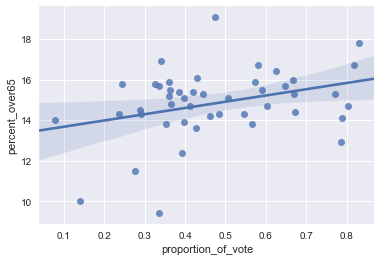

In [36]:
# Only % over 65 & % foreign born correlate with the proportion of votes for Trump.
# Overall, there did not appear to be any strong factors that determined whether or not a 
# person voted for Donald Trump.

# Proportion of vote for Trump vs. % of people over 65 per state:
# Sates with higher percentage of people over 65 were more likely to vote for Trump,
# although this is a weak correlation:
g = sns.regplot(Trump_prop_vote_per_state.proportion_of_vote,county_facts_of_interest_GOP.percent_over65)

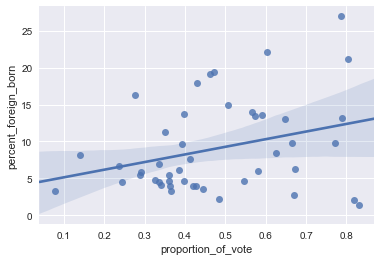

In [37]:
# Proportion of vote for Trump vs. % of people foreign-born per state:
# States with higher percentage of foreign-born population, were more likely to 
# vote for Trump, although again this is a weak correlation:
g = sns.regplot(Trump_prop_vote_per_state.proportion_of_vote,county_facts_of_interest_GOP.percent_foreign_born)

In [38]:
# For Ted Cruz:
Cruz_correlations_state = []
for column in range(0,county_facts_of_interest_GOP.columns.size):
    r, p_value = scipy.stats.pearsonr(Cruz_prop_vote_per_state.proportion_of_vote,
                                      county_facts_of_interest_GOP[county_facts_of_interest_GOP.columns[column]])
    Cruz_correlations_state.append([county_facts_of_interest_GOP.columns[column],r,p_value])

In [39]:
Cruz_correlations_state

[['percent_over65', -0.47575838883015303, 0.00083269243007226979],
 ['percent_women', -0.38744215386627118, 0.0078086384576833796],
 ['percent_two_races', 0.052478784642388338, 0.72906323036927789],
 ['percent_black', -0.043110102157754536, 0.77604827755602435],
 ['percent_hispanic', -0.070836974987502299, 0.63992318696672279],
 ['percent_foreign_born', -0.30343484527254977, 0.040367442096381753],
 ['percent_college_grad', -0.3560714336930631, 0.015152115339688329],
 ['med_household_income', -0.18422057416380333, 0.22035624707495613],
 ['percent_below_poverty', 0.10263327507972532, 0.49730793019490693],
 ['percent_veterans', -0.036329608464423464, 0.81056484397713624],
 ['percent_priv_nonfarm_employ', -0.12968227340617136, 0.39035272932221521]]

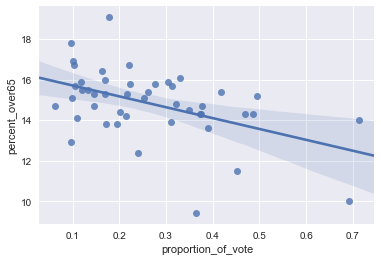

In [40]:
#There were more factors that correlated with proportion of votes for Ted Cruz:
# percent_over65, percent_women, percent_foreign_born, percent_college_grad

# Proportion of vote for Cruz vs. % of people over 65 per state:
# Cruz got lower proportion of vote in states with higher proportion of > 65 voters
g = sns.regplot(Cruz_prop_vote_per_state.proportion_of_vote,county_facts_of_interest_GOP.percent_over65)

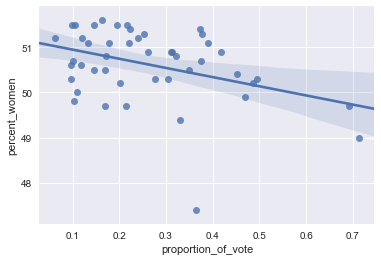

In [41]:
# Proportion of vote for Cruz vs. % of women per state:
# Cruz got lower proportion of vote in states with higher proportion of women
g = sns.regplot(Cruz_prop_vote_per_state.proportion_of_vote,county_facts_of_interest_GOP.percent_women)


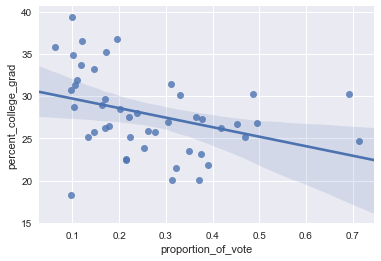

In [42]:
# Proportion of vote for Cruz vs. % college grads per state:
# Cruz got lower proportion of vote in states with higher proportion of college grads.
# So voters who were more educated were less likely to vote for Cruz. 
g = sns.regplot(Cruz_prop_vote_per_state.proportion_of_vote,county_facts_of_interest_GOP.percent_college_grad)


In [43]:
# For John Kasich:
Kasich_correlations_state = []
for column in range(0,county_facts_of_interest_GOP.columns.size):
    r, p_value = scipy.stats.pearsonr(Kasich_prop_vote_per_state.proportion_of_vote,
                                      county_facts_of_interest_GOP[county_facts_of_interest_GOP.columns[column]])
    Kasich_correlations_state.append([county_facts_of_interest_GOP.columns[column],r,p_value])

In [44]:
Kasich_correlations_state

[['percent_over65', 0.1927031568832743, 0.19946656671902369],
 ['percent_women', 0.35943526254616393, 0.014154281304932364],
 ['percent_two_races', -0.088409863774245603, 0.55903943723657479],
 ['percent_black', -0.014448461147941233, 0.92407473469343371],
 ['percent_hispanic', -0.13421730672158083, 0.37384881035359352],
 ['percent_foreign_born', 0.10193634346820583, 0.50024875603752239],
 ['percent_college_grad', 0.46674058735098906, 0.0010763649321496433],
 ['med_household_income', 0.28580825957533951, 0.054169895935810154],
 ['percent_below_poverty', -0.28785806896265997, 0.05239201541782907],
 ['percent_veterans', -0.31829305069955588, 0.031101528692781558],
 ['percent_priv_nonfarm_employ', 0.43828398018567438, 0.0023149105482488659]]

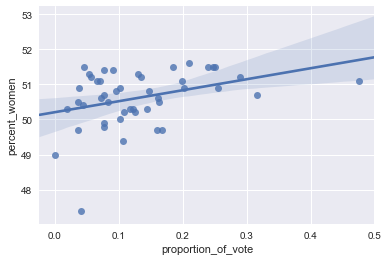

In [45]:
# Factors that significantly correlated with proportion of votes for Kasich:
# percent_women, percent_college_grad, percent_veterans, percent_priv_nonfarm_employ

# Proportion of vote for Kasich vs. % women per state:
# Kasich received a higher proportion of votes in states with higher proportion of women: 
g = sns.regplot(Kasich_prop_vote_per_state.proportion_of_vote,county_facts_of_interest_GOP.percent_women)


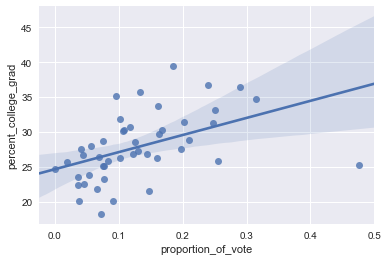

In [46]:
# Proportion of vote for Kasich vs. % college grad per state:
# Kasich received a higher proportion of votes in states with higher proportion of 
# college grads: 
g = sns.regplot(Kasich_prop_vote_per_state.proportion_of_vote,county_facts_of_interest_GOP.percent_college_grad)


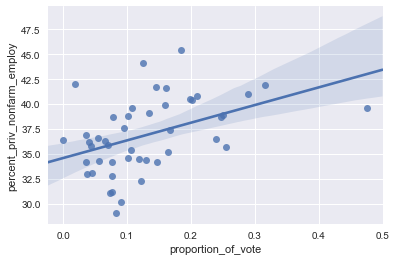

In [47]:
# Proportion of vote for Kasich vs. % in private nonfarm employment (employment rate):
# Kasich received a higher proportion of votes in states with higher percentage of persons
# in private nonfarm employment: 
g = sns.regplot(Kasich_prop_vote_per_state.proportion_of_vote,county_facts_of_interest_GOP.percent_priv_nonfarm_employ)

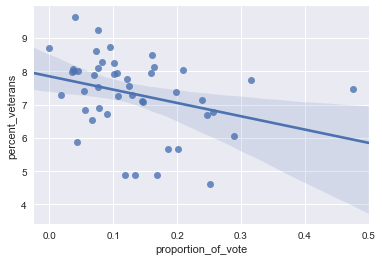

In [48]:
# Proportion of vote for Kasich vs. % percent_veterans per state:
# Kasich received a lower proportion of votes in states with higher proportion of 
# veterans, although this may be driven by outliers: 
g = sns.regplot(Kasich_prop_vote_per_state.proportion_of_vote,county_facts_of_interest_GOP.percent_veterans)

In [49]:
# Overall, it appears that out of the factors investigated, none really strongly related to
# the proportion of votes that Trump received (maybe older people preferred Trump). 
# However, it does appear that Cruz appealed to men and to those who were less educated, while
# Kasich appealed to women and to those who were more educated (and also in states with more 
# employment).

# Some of the results of the Republican primaries might be affected by effects of later races.
# That is, some people chose to vote for Trump because other candidates dropped out or because
# he was the presumed candidate in the later races. I next want to investigate what the 
# correlations look like when you only take the earlier races into account.

# I'm not going to do the same for the Dem race, since I think that it was pretty divided all
# the way to the end and, for the most part, people did not change their mind on who to vote 
# for based on the presumtive nominee. 

# I'm going to analyze only the primaries where Rubio was still in the race (first 27 primaries. 
# Primaries/Caucuses up to 3/22/2016:
GOP_initial_primary_states = list(Rubio_prop_vote_per_state.state)
#choose only the early states from county_facts:
county_facts_of_interest_GOP_early = county_facts_of_interest.loc[GOP_initial_primary_states]

#choose only the early states from Trump_prop_vote_per_state
Trump_prop_vote_per_state = Trump_prop_vote_per_state.reset_index().set_index('state')
Trump_prop_vote_per_state_early = Trump_prop_vote_per_state.loc[GOP_initial_primary_states]

#choose only the early states from Cruz_prop_vote_per_state
Cruz_prop_vote_per_state = Cruz_prop_vote_per_state.reset_index().set_index('state')
Cruz_prop_vote_per_state_early = Cruz_prop_vote_per_state.loc[GOP_initial_primary_states]

#choose only the early states from Kasich_prop_vote_per_state
Kasich_prop_vote_per_state = Kasich_prop_vote_per_state.reset_index().set_index('state')
Kasich_prop_vote_per_state_early = Kasich_prop_vote_per_state.loc[GOP_initial_primary_states]


In [50]:
# Let's see if any new factors correlate with prefernce to vote for Donald Trump, now that we are only looking
# at early races:
Trump_correlations_state_early = []
for column in range(0,county_facts_of_interest_GOP_early.columns.size):
    r, p_value = scipy.stats.pearsonr(Trump_prop_vote_per_state_early.proportion_of_vote,
                                      county_facts_of_interest_GOP_early[county_facts_of_interest_GOP_early.columns[column]])
    Trump_correlations_state_early.append([county_facts_of_interest_GOP_early.columns[column],r,p_value])

In [51]:
Trump_correlations_state_early
# In the ealry races, percent_women (states with higher % of women were more likely to vote for Trump) and 
# percent_black (states with higher % african americans were more likely to vote for Trump) correlated with Trump
# proportion of votes. (hard to believe!)

[['percent_over65', 0.2292153585022533, 0.2501140032225373],
 ['percent_women', 0.46493611270145235, 0.014544126106100551],
 ['percent_two_races', 0.093573063171652981, 0.64248047902063332],
 ['percent_black', 0.46775263643160259, 0.013881118680592804],
 ['percent_hispanic', -0.016302805861224869, 0.93567373922489494],
 ['percent_foreign_born', 0.34338692038717811, 0.079493793552999181],
 ['percent_college_grad', 0.062678880445143886, 0.75611739993668592],
 ['med_household_income', -0.078379407595032091, 0.6975731347365044],
 ['percent_below_poverty', 0.28844624414570935, 0.14453452519827323],
 ['percent_veterans', -0.29946333868682296, 0.12914116522713856],
 ['percent_priv_nonfarm_employ', -0.016456861461440663, 0.93506713477900583]]

In [52]:
# Early voting for Cruz:
Cruz_correlations_state_early = []
for column in range(0,county_facts_of_interest_GOP_early.columns.size):
    r, p_value = scipy.stats.pearsonr(Cruz_prop_vote_per_state_early.proportion_of_vote,
                                      county_facts_of_interest_GOP_early[county_facts_of_interest_GOP_early.columns[column]])
    Cruz_correlations_state_early.append([county_facts_of_interest_GOP_early.columns[column],r,p_value])

In [53]:
Cruz_correlations_state_early
# In the early races, it looks like percent_over65, percent_women, percent_college_grad are all still negatively 
# correlated with proportion of votes for Cruz. That is, voters who were over 65, women, and more educated were 
# less likely to vote for Cruz.

[['percent_over65', -0.40605511370224445, 0.035588847336373471],
 ['percent_women', -0.43961895070527324, 0.021763061921841183],
 ['percent_two_races', 0.069287366863141214, 0.73129396919997358],
 ['percent_black', -0.11219075083474091, 0.57743229216826408],
 ['percent_hispanic', 0.16248612807891416, 0.4180817362516791],
 ['percent_foreign_born', -0.20448074929993154, 0.30626149120627405],
 ['percent_college_grad', -0.39218399283753608, 0.043042287923835604],
 ['med_household_income', -0.14169451252745008, 0.48081231734411345],
 ['percent_below_poverty', 0.12515302534633169, 0.533944852558081],
 ['percent_veterans', 0.041045069337761302, 0.83892415390017305],
 ['percent_priv_nonfarm_employ', -0.37288912667348284, 0.055410076912416763]]

In [54]:
# Early voting for Kasich:
Kasich_correlations_state_early = []
for column in range(0,county_facts_of_interest_GOP_early.columns.size):
    r, p_value = scipy.stats.pearsonr(Kasich_prop_vote_per_state_early.proportion_of_vote,
                                      county_facts_of_interest_GOP_early[county_facts_of_interest_GOP_early.columns[column]])
    Kasich_correlations_state_early.append([county_facts_of_interest_GOP_early.columns[column],r,p_value])

In [55]:
Kasich_correlations_state_early
# In the early races, only percent_priv_nonfarm_employ correlates with proportion of votes for Kasich.
# Kasich received a higher proportion of votes in states with higher percentage of persons
# in private nonfarm employment

[['percent_over65', 0.27941626473739967, 0.15810189671182345],
 ['percent_women', 0.27279337356072958, 0.16861168031831769],
 ['percent_two_races', -0.070872887130729451, 0.72537630728261604],
 ['percent_black', -0.1292326443964652, 0.52058741092486926],
 ['percent_hispanic', -0.2830812531262169, 0.15249032508588345],
 ['percent_foreign_born', -0.10067171469411725, 0.61733888819654914],
 ['percent_college_grad', 0.34937131557749673, 0.074057625387706646],
 ['med_household_income', 0.081764959730005596, 0.6851546458010489],
 ['percent_below_poverty', -0.13406546789790599, 0.50497593316526301],
 ['percent_veterans', -0.24166163527376247, 0.22459818567570641],
 ['percent_priv_nonfarm_employ', 0.41331798402402642, 0.032120503681020061]]

In [56]:
# Early voting for Marco Rubio:
Rubio_correlations_state_early = []
for column in range(0,county_facts_of_interest_GOP_early.columns.size):
    r, p_value = scipy.stats.pearsonr(Rubio_prop_vote_per_state.proportion_of_vote,
                                      county_facts_of_interest_GOP_early[county_facts_of_interest_GOP_early.columns[column]])
    Rubio_correlations_state_early.append([county_facts_of_interest_GOP_early.columns[column],r,p_value])

In [57]:
Rubio_correlations_state_early
#none of these factors seem to correlate with the proportion of votes for Rubio (not even close).

[['percent_over65', 0.077145658185972008, 0.70211779980938127],
 ['percent_women', -0.063477922897794789, 0.7531028244855924],
 ['percent_two_races', -0.036750903764919352, 0.85559190955006725],
 ['percent_black', -0.064231293727524133, 0.75026378740946398],
 ['percent_hispanic', 0.2810977346184208, 0.15550941094372306],
 ['percent_foreign_born', 0.27032285648446452, 0.17265525900372261],
 ['percent_college_grad', 0.056831083349263241, 0.77828313835635365],
 ['med_household_income', 0.043377425005060505, 0.82989901303127644],
 ['percent_below_poverty', -0.099624860712468483, 0.62102110224582052],
 ['percent_veterans', 0.30040371930648424, 0.1278849407420253],
 ['percent_priv_nonfarm_employ', -0.067062524256964171, 0.73962307856206699]]

In [58]:
#What if we look at the COUNTY level? We will get more data points this way. 

#Look at fips numbers:
primary_results = primary_results.reset_index().set_index('fips')
test = primary_results[primary_results.index > 60000] #there shouldn't be any states with fips > 600000
test #wow, there are alot of fips over 60,000! What's going on???

,index,state,state_abbreviation,county,party,candidate,votes,fraction_votes
fips,,,,,,,,
90200101.0,469,Alaska,AK,State House District 1,Democrat,Bernie Sanders,9,0.750
90200101.0,470,Alaska,AK,State House District 1,Democrat,Hillary Clinton,3,0.250
90200110.0,471,Alaska,AK,State House District 10,Democrat,Bernie Sanders,8,0.800
90200110.0,472,Alaska,AK,State House District 10,Democrat,Hillary Clinton,2,0.200
90200111.0,473,Alaska,AK,State House District 11,Democrat,Bernie Sanders,9,0.818
90200111.0,474,Alaska,AK,State House District 11,Democrat,Hillary Clinton,2,0.182
90200112.0,475,Alaska,AK,State House District 12,Democrat,Bernie Sanders,10,1.000
90200112.0,476,Alaska,AK,State House District 12,Democrat,Hillary Clinton,0,0.000
90200113.0,477,Alaska,AK,State House District 13,Democrat,Bernie Sanders,5,0.714


In [59]:
# First, we need to separate votes for each candidate for each county:

#Set candidate as index
primary_results = primary_results.reset_index().set_index('candidate')

#Democrat candidates:
#Hillary Clinton- 49 states, missing Minn
Clinton_per_county = primary_results.loc['Hillary Clinton']#4205- 1150 more than 3055 counties from county_facts??
#Bernie Sanders- 49 states, missing Minn
Sanders_per_county = primary_results.loc['Bernie Sanders']#4205

#Republican candidates: note that I am not analyzing Ben Carson & others, 
#since many dropped out of the race early. 
#Donald Trump- 46 states, missing Colorado, Maine, Minn, North Dakota
Trump_per_county = primary_results.loc['Donald Trump'] #3586
Trump_per_county.fips.unique().size #3577
#Ted Cruz- 46 states, missing Colorado, Maine, Minn, North Dakota 
Cruz_per_county = primary_results.loc['Ted Cruz'] #3586
#John Kasich- 46 states, missing Colorado, Maine, Minn, North Dakota 
Kasich_per_county = primary_results.loc['John Kasich'] #3586
#Marco Rubio- 27 states, dropped out early
Rubio_per_county = primary_results.loc['Marco Rubio'] #2555

In [60]:
#there are way more values for each candidate than counties in the US. We need to figure why:
# For Dem Candidates:

#test = Sanders_per_county.fips.sort_values()
#test
#test = Sanders_per_county.reset_index().set_index('fips')
#Look to see what states are showing fips that are larger than 60000
#test = test[test.index > 60000]
#test.iloc[1301:1400]#AK, CT, IL (chicago, cook suburbs), KS, ME, MA, ND, RI, VT

#test = Sanders_per_county.reset_index().set_index('state_abbreviation')
#test.loc['VT']
#AK- voting broken up into state house districts, rather than counties. does not match. Due to caucus.
#CT- has 169 entries, but only 8 counties. Looks like the info is broken up into cites, rather than counties.
#IL- for some reason, Chicago & cook suburbs were broken up instead of being combined into one-- cook county
#KS- broken up into 4 congressional districts, rather than counties. Due to caucus.
#ME- has 497 entries, but only 16 counties. Looks again like this is broken up by city, rather than county.
#MA- has 351 entries, but only 14 counties. Looks again like this is broken up by city, rather than county.
#ND- broken up into 47 districts, instead of 53 counties. Due to caucus.
#RI- has 40 entries, but only 5 counties. Looks again like this is broken up by city, rather than county.
#VT- has 246 entries, but only 14 counties. Looks again like this is broken up by city, rather than county.

#We can fix the IL problem, but the other 8 states are harder. Perhaps it would be just best to exclude them from the 
#analyses?

In [61]:
#Investigate fips in GOP candidates:
test = Trump_per_county.reset_index().set_index('fips')
#Look to see what states are showing fips that are larger than 60000
test = test[test.index > 60000]
test.iloc[701:1001]#AK, CT, IL (chicago, cook suburbs), KS, MA, RI, VT, WY
#Same problems as the Democratic candidates. ME & ND, MN data missing all together. 
#WY- has 12 entries, but 23 counties in total. All but one of Wyoming's 23 counties were grouped 
#into pairs of two (Laramie County was alone) to report results. 

,candidate,index,state,state_abbreviation,county,party,votes,fraction_votes
fips,,,,,,,,
95000095.0,Donald Trump,21997,Vermont,VT,Huntington,Republican,48,0.338
95000096.0,Donald Trump,22002,Vermont,VT,Hyde Park,Republican,91,0.355
95000097.0,Donald Trump,22007,Vermont,VT,Ira,Republican,17,0.293
95000098.0,Donald Trump,22012,Vermont,VT,Irasburg,Republican,42,0.331
95000099.0,Donald Trump,22017,Vermont,VT,Isle La Motte,Republican,44,0.524
95000100.0,Donald Trump,22022,Vermont,VT,Jamaica,Republican,22,0.349
95000101.0,Donald Trump,22027,Vermont,VT,Jay,Republican,17,0.386
95000102.0,Donald Trump,22032,Vermont,VT,Jericho,Republican,166,0.277
95000103.0,Donald Trump,22037,Vermont,VT,Johnson,Republican,51,0.295


In [62]:
#Combine Cook Suburbs & Chicago into Cook County:
primary_results = primary_results.reset_index().set_index(['state_abbreviation','county','party','candidate'])

foo= primary_results.loc['IL','Cook Suburbs'] #Cook Suburbs has 6 candidates
foo

/Users/saraszczepanski/Library/Python/3.6/lib/python/site-packages/ipykernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.


fips  index     state   votes  \
party      candidate                                              
Democrat   Bernie Sanders   91700104.0   4462  Illinois  212428   
           Hillary Clinton  91700104.0   4463  Illinois  249217   
Republican Donald Trump     91700104.0   4700  Illinois   91520   
           John Kasich      91700104.0   4701  Illinois   53481   
           Marco Rubio      91700104.0   4702  Illinois   21000   
           Ted Cruz         91700104.0   4703  Illinois   50667   

                            fraction_votes  
party      candidate                        
Democrat   Bernie Sanders            0.457  
           Hillary Clinton           0.536  
Republican Donald Trump              0.415  
           John Kasich               0.242  
           Marco Rubio               0.095  
           Ted Cruz                  0.230

In [63]:
foo2= primary_results.loc['IL','Chicago'] #Cook Suburbs has 6 candidates
foo2

/Users/saraszczepanski/Library/Python/3.6/lib/python/site-packages/ipykernel/__main__.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


fips  index     state   votes  \
party      candidate                                              
Democrat   Bernie Sanders   91700103.0   4450  Illinois  311225   
           Hillary Clinton  91700103.0   4451  Illinois  366954   
Republican Donald Trump     91700103.0   4676  Illinois   32858   
           John Kasich      91700103.0   4677  Illinois   21654   
           Marco Rubio      91700103.0   4678  Illinois   10466   
           Ted Cruz         91700103.0   4679  Illinois   17737   

                            fraction_votes  
party      candidate                        
Democrat   Bernie Sanders            0.454  
           Hillary Clinton           0.536  
Republican Donald Trump              0.387  
           John Kasich               0.255  
           Marco Rubio               0.123  
           Ted Cruz                  0.209

In [64]:
Sanders_Chicago_votes = primary_results.loc['IL','Chicago','Democrat','Bernie Sanders'].votes
Clinton_Chicago_votes = primary_results.loc['IL','Chicago','Democrat','Hillary Clinton'].votes

Sanders_Cook_Burbs_votes = primary_results.loc['IL','Cook Suburbs','Democrat','Bernie Sanders'].votes
Clinton_Cook_Burbs_votes = primary_results.loc['IL','Cook Suburbs','Democrat','Hillary Clinton'].votes

Trump_Chicago_votes = primary_results.loc['IL','Chicago','Republican','Donald Trump'].votes
Cruz_Chicago_votes = primary_results.loc['IL','Chicago','Republican','Ted Cruz'].votes
Kasich_Chicago_votes = primary_results.loc['IL','Chicago','Republican','John Kasich'].votes
Rubio_Chicago_votes = primary_results.loc['IL','Chicago','Republican','Marco Rubio'].votes

Trump_Cook_Burbs_votes = primary_results.loc['IL','Cook Suburbs','Republican','Donald Trump'].votes
Cruz_Cook_Burbs_votes = primary_results.loc['IL','Cook Suburbs','Republican','Ted Cruz'].votes
Kasich_Cook_Burbs_votes = primary_results.loc['IL','Cook Suburbs','Republican','John Kasich'].votes
Rubio_Cook_Burbs_votes = primary_results.loc['IL','Cook Suburbs','Republican','Marco Rubio'].votes

Sanders_Cook_County_votes = Sanders_Chicago_votes + Sanders_Cook_Burbs_votes
Clinton_Cook_County_votes = Clinton_Chicago_votes + Clinton_Cook_Burbs_votes
Trump_Cook_County_votes = Trump_Chicago_votes + Trump_Cook_Burbs_votes
Cruz_Cook_County_votes = Cruz_Chicago_votes + Cruz_Cook_Burbs_votes
Kasich_Cook_County_votes = Kasich_Chicago_votes + Kasich_Cook_Burbs_votes
Rubio_Cook_County_votes = Rubio_Chicago_votes + Rubio_Cook_Burbs_votes

Sanders_Cook_County_prop_votes = Sanders_Cook_County_votes/(Sanders_Cook_County_votes+Clinton_Cook_County_votes)
Clinton_Cook_County_prop_votes = Clinton_Cook_County_votes/(Sanders_Cook_County_votes+Clinton_Cook_County_votes)
Trump_Cook_County_prop_votes = Trump_Cook_County_votes/(Trump_Cook_County_votes+Cruz_Cook_County_votes+
                                                       Kasich_Cook_County_votes+Rubio_Cook_County_votes)
Cruz_Cook_County_prop_votes = Cruz_Cook_County_votes/(Trump_Cook_County_votes+Cruz_Cook_County_votes+
                                                       Kasich_Cook_County_votes+Rubio_Cook_County_votes)

Kasich_Cook_County_prop_votes = Kasich_Cook_County_votes/(Trump_Cook_County_votes+Cruz_Cook_County_votes+
                                                       Kasich_Cook_County_votes+Rubio_Cook_County_votes)
Rubio_Cook_County_prop_votes = Rubio_Cook_County_votes/(Trump_Cook_County_votes+Cruz_Cook_County_votes+
                                                       Kasich_Cook_County_votes+Rubio_Cook_County_votes)

In [65]:
#create new dataframe of Cook County info:
#state,state_abbreviation, county, fips, party, candidate,votes,fraction_votes
data = {'state': ['Illinois','Illinois','Illinois','Illinois','Illinois','Illinois'],
        'state_abbreviation': ['IL','IL','IL','IL','IL','IL'],
        'county': ['Cook','Cook','Cook','Cook','Cook','Cook'],
        'fips': [17031,17031,17031,17031,17031,17031],
        'party': ['Democrat','Democrat','Republican','Republican','Republican','Republican'],
        'candidate': ['Bernie Sanders','Hillary Clinton','Donald Trump','Ted Cruz','John Kasich','Marco Rubio'],
        'votes': [Sanders_Cook_County_votes,Clinton_Cook_County_votes,Trump_Cook_County_votes,Cruz_Cook_County_votes,
         Kasich_Cook_County_votes,Rubio_Cook_County_votes],
        'fraction_votes': [Sanders_Cook_County_prop_votes,Clinton_Cook_County_prop_votes,Trump_Cook_County_prop_votes,
        Cruz_Cook_County_prop_votes,Kasich_Cook_County_prop_votes,Rubio_Cook_County_prop_votes]
       }
Cook_County_info = pd.DataFrame(data)

In [66]:
Cook_County_info

,candidate,county,fips,fraction_votes,party,state,state_abbreviation,votes
0,Bernie Sanders,Cook,17031,0.459416,Democrat,Illinois,IL,523653
1,Hillary Clinton,Cook,17031,0.540584,Democrat,Illinois,IL,616171
2,Donald Trump,Cook,17031,0.415448,Republican,Illinois,IL,124378
3,Ted Cruz,Cook,17031,0.228483,Republican,Illinois,IL,68404
4,John Kasich,Cook,17031,0.250966,Republican,Illinois,IL,75135
5,Marco Rubio,Cook,17031,0.105103,Republican,Illinois,IL,31466


In [67]:
primary_results = primary_results.reset_index()
primary_results = primary_results.drop('index',1)

In [68]:
#Concatenate Cook_County_info to primary_results:
primary_results_combined = pd.concat([primary_results,Cook_County_info], axis=0)
primary_results_combined

,candidate,county,fips,fraction_votes,party,state,state_abbreviation,votes
0,Bernie Sanders,Autauga,1001.0,0.182000,Democrat,Alabama,AL,544
1,Hillary Clinton,Autauga,1001.0,0.800000,Democrat,Alabama,AL,2387
2,Bernie Sanders,Baldwin,1003.0,0.329000,Democrat,Alabama,AL,2694
3,Hillary Clinton,Baldwin,1003.0,0.647000,Democrat,Alabama,AL,5290
4,Bernie Sanders,Barbour,1005.0,0.078000,Democrat,Alabama,AL,222
5,Hillary Clinton,Barbour,1005.0,0.906000,Democrat,Alabama,AL,2567
6,Bernie Sanders,Bibb,1007.0,0.197000,Democrat,Alabama,AL,246
7,Hillary Clinton,Bibb,1007.0,0.755000,Democrat,Alabama,AL,942
8,Bernie Sanders,Blount,1009.0,0.386000,Democrat,Alabama,AL,395
9,Hillary Clinton,Blount,1009.0,0.551000,Democrat,Alabama,AL,564


In [69]:
#set index as county, so we can delete Chicago and Cook Suburbs
primary_results_combined = primary_results_combined.reset_index().set_index('county')

In [70]:
#delete chicago/cook sub, should be left with Cook County only
primary_results_combined = primary_results_combined.drop(['Chicago','Cook Suburbs'])
primary_results_combined.loc['Cook']

,index,candidate,fips,fraction_votes,party,state,state_abbreviation,votes
county,,,,,,,,
Cook,3101,Bernie Sanders,13075.0,0.225000,Democrat,Georgia,GA,171
Cook,3102,Hillary Clinton,13075.0,0.762000,Democrat,Georgia,GA,580
Cook,3527,Ben Carson,13075.0,0.079000,Republican,Georgia,GA,178
Cook,3528,Donald Trump,13075.0,0.547000,Republican,Georgia,GA,1229
Cook,3529,John Kasich,13075.0,0.020000,Republican,Georgia,GA,46
Cook,3530,Marco Rubio,13075.0,0.107000,Republican,Georgia,GA,240
Cook,3531,Ted Cruz,13075.0,0.231000,Republican,Georgia,GA,519
Cook,0,Bernie Sanders,17031.0,0.459416,Democrat,Illinois,IL,523653
Cook,1,Hillary Clinton,17031.0,0.540584,Democrat,Illinois,IL,616171


In [71]:
#reset index to state, so that we can get rid of the states that do not have proper county data:
primary_results_combined = primary_results_combined.reset_index().set_index('state_abbreviation')

In [72]:
#Primary Results for Dem candidates:
#We need to remove AK, CT, KS, ME, MA, ND, RI, VT (already missing MN)
primary_results_by_county_Dem = primary_results_combined[(primary_results_combined.index != 'AK') & 
                                                         (primary_results_combined.index != 'CT') &
                                                         (primary_results_combined.index != 'KS') & 
                                                         (primary_results_combined.index != 'ME') & 
                                                         (primary_results_combined.index != 'MA') & 
                                                         (primary_results_combined.index != 'ND') &
                                                         (primary_results_combined.index != 'RI') & 
                                                         (primary_results_combined.index != 'VT')]
#primary_results_by_county_Dem.shape #17633
#primary_results_combined.shape #24605
primary_results_by_county_Dem.index.unique()

Index(['AL', 'AZ', 'AR', 'CA', 'CO', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN',
       'IA', 'KY', 'LA', 'MD', 'MI', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
       'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VA', 'WA', 'WV', 'WI', 'WY'],
      dtype='object', name='state_abbreviation')

In [73]:
#Primary Results for GOP candidates:
#We need to remove AK, CT, KS, ME, MA, ND, RI, VT, WY (already missing MN)
primary_results_by_county_GOP = primary_results_combined[(primary_results_combined.index != 'AK') & 
                                                         (primary_results_combined.index != 'CT') &
                                                         (primary_results_combined.index != 'KS') & 
                                                         (primary_results_combined.index != 'ME') & 
                                                         (primary_results_combined.index != 'MA') & 
                                                         (primary_results_combined.index != 'ND') &
                                                         (primary_results_combined.index != 'RI') & 
                                                         (primary_results_combined.index != 'VT') &
                                                         (primary_results_combined.index != 'WY')]

primary_results_by_county_GOP.index.unique()

Index(['AL', 'AZ', 'AR', 'CA', 'CO', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN',
       'IA', 'KY', 'LA', 'MD', 'MI', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
       'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VA', 'WA', 'WV', 'WI'],
      dtype='object', name='state_abbreviation')

In [74]:
#Set candidate as index
primary_results_by_county_Dem = primary_results_by_county_Dem.reset_index().set_index('candidate')
primary_results_by_county_GOP = primary_results_by_county_GOP.reset_index().set_index('candidate')

In [75]:
# Separate votes for each candidate for each county (again):

#Democrat candidates:
#Hillary Clinton- 
Clinton_per_county = primary_results_by_county_Dem.loc['Hillary Clinton']#2809 counties 
#Bernie Sanders- 
Sanders_per_county = primary_results_by_county_Dem.loc['Bernie Sanders']#2809
#Republican candidates: note that I am not analyzing Ben Carson & others, 
#since many dropped out of the race early. 
#Donald Trump- 
Trump_per_county = primary_results_by_county_GOP.loc['Donald Trump'] #2722
#Ted Cruz- 
Cruz_per_county = primary_results_by_county_GOP.loc['Ted Cruz'] #2722
#John Kasich- 
Kasich_per_county = primary_results_by_county_GOP.loc['John Kasich'] #2722
#Marco Rubio- 
Rubio_per_county = primary_results_by_county_GOP.loc['Marco Rubio'] #1901


In [76]:
# County_facts data by county for Democratic candidates:
# Remove all rows related to Minnesota from data first, so we don't include MN counties in county_facts.
# Also remove AK, CT, KS, ME, MA, ND, RI, & VT, since they are msising from primary_results
county_facts_Dem = county_facts[(county_facts.state_abbreviation != 'MN') &
                            (county_facts.state_abbreviation != 'AK') &
                            (county_facts.state_abbreviation != 'CT') &
                            (county_facts.state_abbreviation != 'KS') &
                            (county_facts.state_abbreviation != 'ME') &
                            (county_facts.state_abbreviation != 'MA') &
                            (county_facts.state_abbreviation != 'ND') &
                            (county_facts.state_abbreviation != 'RI') &
                            (county_facts.state_abbreviation != 'VT')] 

county_facts_Dem.state_abbreviation.unique()

array([nan, 'AL', 'AZ', 'AR', 'CA', 'CO', 'DE', 'DC', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KY', 'LA', 'MD', 'MI', 'MS', 'MO', 'MT',
       'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [77]:
# County_facts data by county for GOP candidates:
# Remove all rows related to Minnesota from data first, so we don't include MN counties in county_facts.
# Also remove AK, CT, KS, ME, MA, ND, RI, VT & WY, since they are missing data from primary_results.
# Also remove CO, since there was no GOP primary in CO this year. 
county_facts_GOP = county_facts[(county_facts.state_abbreviation != 'MN') &
                            (county_facts.state_abbreviation != 'AK') &
                            (county_facts.state_abbreviation != 'CT') &
                            (county_facts.state_abbreviation != 'KS') &
                            (county_facts.state_abbreviation != 'ME') &
                            (county_facts.state_abbreviation != 'MA') &
                            (county_facts.state_abbreviation != 'ND') &
                            (county_facts.state_abbreviation != 'RI') &
                            (county_facts.state_abbreviation != 'VT') &
                            (county_facts.state_abbreviation != 'WY') &
                            (county_facts.state_abbreviation != 'CO') ] 

county_facts_GOP.state_abbreviation.unique()

array([nan, 'AL', 'AZ', 'AR', 'CA', 'DE', 'DC', 'FL', 'GA', 'HI', 'ID',
       'IL', 'IN', 'IA', 'KY', 'LA', 'MD', 'MI', 'MS', 'MO', 'MT', 'NE',
       'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'SC',
       'SD', 'TN', 'TX', 'UT', 'VA', 'WA', 'WV', 'WI'], dtype=object)

In [78]:
#set up index in order to investigate country-level numbers: 
#for Dem candidates:
all_counties_index_Dem = county_facts_Dem['area_name'].str.contains('County|Area|city|Borough|Parish|City|Municipality')

all_counties_Dem = county_facts_Dem['area_name'][all_counties_index_Dem] 
all_counties_Dem.size #2811.

2811

In [79]:
#set up index in order to investigate country-level numbers: 
#for GOP candidates:
all_counties_index_GOP = county_facts_GOP['area_name'].str.contains('County|Area|city|Borough|Parish|City|Municipality')

all_counties_GOP = county_facts_GOP['area_name'][all_counties_index_GOP] 
all_counties_GOP.size #2724. 

2724

In [80]:
#all_counties_Dem is still 2 values longer than Clinton_per_county & all_counties_GOP is 2 values longer 
#than Trump_per_county. What is going on??

#state info from county_facts:
states_list = county_facts_Dem.state_abbreviation[all_counties_index_Dem]
def count_counties(votes_per_county,states_list):
    votes_per_county = votes_per_county.reset_index().set_index('state_abbreviation')
    county_count = []
    for state in votes_per_county.index.unique():
        states = states_list[states_list == state]
        #state,number of counties in votes_per_county, number of counties in 
        county_count.append([state,votes_per_county.loc[state].shape[0], states.shape[0]])
    return county_count

In [81]:
county_count = count_counties(Clinton_per_county,states_list)

In [82]:
county_count#HI & VA does not match. HI has 5 counties. VA has 133 counties. 

[['AL', 67, 67],
 ['AZ', 15, 15],
 ['AR', 75, 75],
 ['CA', 58, 58],
 ['CO', 64, 64],
 ['DE', 3, 3],
 ['FL', 67, 67],
 ['GA', 159, 159],
 ['HI', 4, 5],
 ['ID', 44, 44],
 ['IL', 102, 102],
 ['IN', 92, 92],
 ['IA', 99, 99],
 ['KY', 120, 120],
 ['LA', 64, 64],
 ['MD', 24, 24],
 ['MI', 83, 83],
 ['MS', 82, 82],
 ['MO', 115, 115],
 ['MT', 56, 56],
 ['NE', 93, 93],
 ['NV', 17, 17],
 ['NH', 10, 10],
 ['NJ', 21, 21],
 ['NM', 33, 33],
 ['NY', 62, 62],
 ['NC', 100, 100],
 ['OH', 88, 88],
 ['OK', 77, 77],
 ['OR', 36, 36],
 ['PA', 67, 67],
 ['SC', 46, 46],
 ['SD', 66, 66],
 ['TN', 95, 95],
 ['TX', 254, 254],
 ['UT', 29, 29],
 ['VA', 133, 134],
 ['WA', 39, 39],
 ['WV', 55, 55],
 ['WI', 72, 72],
 ['WY', 23, 23]]

In [83]:
county_facts_Dem[county_facts_Dem.state_abbreviation == 'HI']

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210,percent_veterans,percent_priv_nonfarm_employ
559,15001,Hawaii County,HI,194190,185079,4.9,185079,6.2,22.0,17.5,50.0,34.3,0.9,0.6,22.0,12.7,29.4,12.3,30.6,87.0,10.9,18.7,91.0,25.6,15729,25.4,85163,65.7,19.0,309800,64909,2.83,24635,51250,18.3,3923,50266,3.4,16499,18900,0.0,1.5,31.9,9.1,3.9,26.4,290120,732242,2566012,14816,874735,958,4028.42,45.9,8.099799,25.884958
560,15003,Honolulu County,HI,991788,953207,4.0,953207,6.5,21.5,15.8,49.2,23.1,3.1,0.4,42.4,9.4,21.6,9.5,19.6,84.6,19.6,27.8,90.3,32.1,82157,27.2,343017,55.5,44.2,556300,309803,3.00,30361,72764,9.8,21173,347954,2.1,60220,74069,1.1,0.0,56.6,9.1,3.3,32.1,8201881,7377106,11518349,12817,4123825,1578,600.74,1586.7,8.283726,35.083506
561,15005,Kalawao County,HI,89,90,-1.1,90,0.0,0.0,29.2,52.8,28.1,0.0,0.0,7.9,48.3,15.7,1.1,27.0,90.1,19.7,33.8,87.7,41.5,3,10.0,113,0.0,25.3,0,46,1.39,45515,59375,14.7,1,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,11.99,7.5,3.370787,0.000000
562,15007,Kauai County,HI,70475,67090,5.0,67091,6.4,22.3,17.4,49.9,33.7,0.7,0.6,31.3,9.1,24.6,10.8,30.1,87.5,15.1,20.9,90.1,25.1,4680,21.4,30346,62.6,25.1,484500,22390,2.99,26658,62052,11.2,1986,25186,1.1,6621,8316,0.0,3.0,35.5,10.2,5.0,31.8,0,209395,1052671,16730,591483,192,619.96,108.2,6.640653,35.737496
563,15009,Maui County,HI,163019,154835,5.3,154834,6.2,22.3,15.1,49.7,35.9,0.9,0.6,28.7,10.7,23.2,11.0,31.3,82.8,17.2,20.7,90.2,25.7,10056,20.8,71467,58.1,37.1,523700,52623,2.93,29517,63512,10.6,4409,60720,-2.1,15150,20097,0.6,1.7,30.3,10.5,3.9,30.0,262749,575929,2474819,17437,2452167,338,1161.52,133.3,6.168606,37.247192


In [84]:
#Set index to state
Clinton_per_county = Clinton_per_county.reset_index().set_index('state_abbreviation')
Sanders_per_county = Sanders_per_county.reset_index().set_index('state_abbreviation')
Trump_per_county = Trump_per_county.reset_index().set_index('state_abbreviation')
Cruz_per_county = Cruz_per_county.reset_index().set_index('state_abbreviation')
Kasich_per_county = Kasich_per_county.reset_index().set_index('state_abbreviation')
Rubio_per_county = Rubio_per_county.reset_index().set_index('state_abbreviation')

In [85]:
Clinton_per_county.loc['HI']#missing Kalawao county from voting info. Must delete Kalawao County from county_facts!

,candidate,county,index,fips,fraction_votes,party,state,votes
state_abbreviation,,,,,,,,
HI,Hillary Clinton,Hawaii,4143,15001.0,0.226,Democrat,Hawaii,1639
HI,Hillary Clinton,Honolulu,4145,15003.0,0.368,Democrat,Hawaii,6686
HI,Hillary Clinton,Kauai,4147,15007.0,0.228,Democrat,Hawaii,607
HI,Hillary Clinton,Maui,4149,15009.0,0.212,Democrat,Hawaii,1195


In [86]:
county_facts_VA = county_facts_Dem[county_facts_Dem.state_abbreviation == 'VA']
county_facts_VA = county_facts_VA.area_name.sort_values()#remember to sort values before running regression!!!
county_facts_VA[10:20]#county_facts has an extra Beford city included, which does not exist IRL. Need to delete
#Bedford city from county_facts! NOTE: Removal of the independent city of Bedford Virginia 
#(FIPS 51515, geo code VA515) and its inclusion in Bedford County, Virginia (51019, VA019) will impact 
#the Lynchburg, VA Metropolitan Statistical Area (31340, IUSA_MLYN). 

2877       Bedford County
2964         Bedford city
2878         Bland County
2879     Botetourt County
2965         Bristol city
2880     Brunswick County
2881      Buchanan County
2882    Buckingham County
2966     Buena Vista city
2883      Campbell County
Name: area_name, dtype: object

In [87]:
Clinton_per_county.loc['VA'].county.sort_values()[10:20]

state_abbreviation
VA        Bedford
VA          Bland
VA      Botetourt
VA        Bristol
VA      Brunswick
VA       Buchanan
VA     Buckingham
VA    Buena Vista
VA       Campbell
VA       Caroline
Name: county, dtype: object

In [88]:
county_facts_Dem[county_facts.area_name == 'Bedford County']

/Users/saraszczepanski/Library/Python/3.6/lib/python/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210,percent_veterans,percent_priv_nonfarm_employ
2288,42009,Bedford County,PA,48946,49768,-1.7,49762,5.0,20.7,20.5,50.1,97.9,0.7,0.2,0.3,0.0,1.0,1.1,97.0,91.9,0.7,3.0,85.2,12.6,4355,28.0,24013,79.8,7.6,120200,20198,2.42,22259,43290,12.6,1043,13299,1.1,3245,4459,0.0,0.0,0.0,0.0,0.0,0.0,728654,295488,581577,11712,70289,66,1012.30,49.2,8.897561,27.170760
2473,47003,Bedford County,TN,46627,45058,3.5,45058,6.7,26.2,14.4,50.9,87.2,8.3,1.2,1.3,0.2,1.9,11.7,77.6,87.3,7.2,11.6,77.5,12.3,3106,26.6,18547,70.0,10.1,114600,16402,2.73,19303,40759,20.0,765,11876,-1.2,2856,3958,0.0,0.0,0.0,0.0,2.7,20.6,1047294,0,340609,7649,35265,171,473.64,95.1,6.661376,25.470221
2877,51019,Bedford County,VA,76583,74866,2.3,68676,4.4,20.4,19.4,50.7,90.0,7.0,0.3,1.2,0.0,1.4,2.0,88.3,90.9,1.7,3.2,87.6,25.0,7104,27.6,35779,85.0,3.6,195400,27233,2.53,28697,57596,8.2,1353,11923,0.4,4549,5647,0.0,0.0,0.0,0.0,0.7,23.3,785359,368955,466545,7029,27892,420,753.02,91.2,9.276210,15.568729


In [89]:
county_facts_Dem[county_facts.area_name == 'Bedford city']

/Users/saraszczepanski/Library/Python/3.6/lib/python/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,SEX255214,RHI125214,RHI225214,RHI325214,RHI425214,RHI525214,RHI625214,RHI725214,RHI825214,POP715213,POP645213,POP815213,EDU635213,EDU685213,VET605213,LFE305213,HSG010214,HSG445213,HSG096213,HSG495213,HSD410213,HSD310213,INC910213,INC110213,PVY020213,BZA010213,BZA110213,BZA115213,NES010213,SBO001207,SBO315207,SBO115207,SBO215207,SBO515207,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210,percent_veterans,percent_priv_nonfarm_employ
2964,51515,Bedford city,VA,0,0,0.0,6222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.5,2.1,3.9,86.3,25.0,641,18.7,0,58.7,27.6,146400,2800,2.07,22322,35593,18.7,315,3824,-11.5,387,589,8.6,0.0,0.0,0.0,0.0,24.9,0,28870,124881,19848,15426,0,6.88,904.6,inf,inf


In [90]:
#Reset index in order to investigate country-level numbers: 

#for Dem candidates:
#set fips as index, so we can easily remove values of Bedford city & Kalawao County
county_facts_Dem = county_facts_Dem.reset_index().set_index('fips')
#remove Bedford city & Kalawao County
county_facts_Dem = county_facts_Dem.drop([51515,15005])

In [91]:
all_counties_index_Dem = county_facts_Dem['area_name'].str.contains('County|Area|city|Borough|Parish|City|Municipality')
all_counties_Dem = county_facts_Dem['area_name'][all_counties_index_Dem] 
all_counties_Dem.size #2809-- this number now matches votes percounty for Clinton & Sanders

2809

In [92]:
#Reset index in order to investigate country-level numbers: 

#for GOP candidates:
#set fips as index, so we can easily remove values of Bedford city & Kalawao County
county_facts_GOP = county_facts_GOP.reset_index().set_index('fips')
#remove Bedford city & Kalawao County
county_facts_GOP = county_facts_GOP.drop([51515,15005])

In [93]:
all_counties_index_GOP = county_facts_GOP['area_name'].str.contains('County|Area|city|Borough|Parish|City|Municipality')
all_counties_GOP = county_facts_GOP['area_name'][all_counties_index_GOP] 
all_counties_GOP.size #2722-- this number now matches votes percounty for Trump,Cruz, & Kasich

2722

In [94]:
#Isolate columns of county_facts that we would like to analyze more:
county_facts_of_interest_by_county_Dem = county_facts_Dem[['area_name', 'state_abbreviation','AGE775214','SEX255214','RHI625214','RHI225214', 
                                       'RHI725214','POP645213', 'EDU685213','INC110213',
                                        'PVY020213','percent_veterans',
                                        'percent_priv_nonfarm_employ']][all_counties_index_Dem]
county_facts_of_interest_by_county_GOP = county_facts_GOP[['area_name', 'state_abbreviation','AGE775214','SEX255214','RHI625214','RHI225214', 
                                       'RHI725214','POP645213', 'EDU685213','INC110213',
                                        'PVY020213','percent_veterans',
                                        'percent_priv_nonfarm_employ']][all_counties_index_GOP]

#rename columns for ease of reading:
new_column_names ={'AGE775214': 'percent_over65','SEX255214': 'percent_women',
                  'RHI625214': 'percent_two_races','RHI225214': 'percent_black',
                  'RHI725214': 'percent_hispanic', 'POP645213': 'percent_foreign_born',
                  'EDU685213': 'percent_college_grad','INC110213': 'med_household_income',
                  'PVY020213': 'percent_below_poverty'}
county_facts_of_interest_by_county_Dem = county_facts_of_interest_by_county_Dem.rename(columns=new_column_names)
county_facts_of_interest_by_county_GOP = county_facts_of_interest_by_county_GOP.rename(columns=new_column_names)

In [95]:
county_facts_of_interest_by_county_Dem = county_facts_of_interest_by_county_Dem.reset_index().set_index('state_abbreviation')
county_facts_of_interest_by_county_GOP = county_facts_of_interest_by_county_GOP.reset_index().set_index('state_abbreviation')

In [96]:
county_facts_of_interest_by_county_GOP.head(100)

,fips,area_name,percent_over65,percent_women,percent_two_races,percent_black,percent_hispanic,percent_foreign_born,percent_college_grad,med_household_income,percent_below_poverty,percent_veterans,percent_priv_nonfarm_employ
state_abbreviation,,,,,,,,,,,,,
AL,1001,Autauga County,13.8,51.4,1.8,18.7,2.7,1.6,20.9,53682,12.1,10.690496,18.268797
AL,1003,Baldwin County,18.7,51.2,1.6,9.6,4.6,3.6,27.7,50221,13.9,9.667634,27.478749
AL,1005,Barbour County,16.5,46.6,0.9,47.6,4.5,2.9,13.4,32911,26.7,7.884851,24.588091
AL,1007,Bibb County,14.8,45.9,0.9,22.1,2.1,1.2,12.1,36447,18.1,5.896205,13.974051
AL,1009,Blount County,17.0,50.5,1.2,1.8,8.7,4.3,12.1,44145,15.8,7.865694,11.777751
AL,1011,Bullock County,14.9,45.3,1.1,70.1,7.5,5.4,12.5,32033,21.6,5.908584,0.000000
AL,1013,Butler County,18.0,53.6,0.8,44.0,1.2,0.8,14.0,29918,28.4,7.375838,28.138549
AL,1015,Calhoun County,16.0,51.8,1.7,21.1,3.5,2.4,16.1,39962,21.9,9.821767,30.082991
AL,1017,Chambers County,18.3,52.3,1.1,39.5,2.0,1.1,11.8,32402,24.1,7.897054,18.872520


In [97]:
# Run regression for each candidate across counties from 41 states (excluding those above for
# various reasons).
# What factors played biggest part in determining strength of support for each
# of the major candidates (Clinton, Sanders, Trump, Cruz, Kasich)? I decided to run a regression
# across counties since this provides many more datapoints (vs. states-- 49 datapoints not
# large enough to run a regression with 8-10 predictors)

In [98]:
#First, we need to identify if any of teh fips numbers are missing, since we will be sorting our data frames by fips.
#county_facts_of_interest_by_county_GOP.fips == 'NaN'
Trump_null = Trump_per_county[Trump_per_county.fips.isnull()]
Trump_null #Missing fips numbers for NH!!!

,candidate,county,index,fips,fraction_votes,party,state,votes
state_abbreviation,,,,,,,,
NH,Donald Trump,Belknap,14610,NaN,0.360110,Republican,New Hampshire,5505
NH,Donald Trump,Carroll,14618,NaN,0.345391,Republican,New Hampshire,4182
NH,Donald Trump,Cheshire,14626,NaN,0.344951,Republican,New Hampshire,4543
NH,Donald Trump,Coos,14634,NaN,0.382915,Republican,New Hampshire,2183
NH,Donald Trump,Grafton,14642,NaN,0.304280,Republican,New Hampshire,4898
NH,Donald Trump,Hillsborough,14650,NaN,0.353724,Republican,New Hampshire,28981
NH,Donald Trump,Merrimack,14658,NaN,0.338175,Republican,New Hampshire,10966
NH,Donald Trump,Rockingham,14666,NaN,0.393710,Republican,New Hampshire,28716
NH,Donald Trump,Strafford,14674,NaN,0.343760,Republican,New Hampshire,7352


In [99]:
Clinton_null = Clinton_per_county[Clinton_per_county.fips.isnull()]
Clinton_null #Missing fips numbers for NH!!!

,candidate,county,index,fips,fraction_votes,party,state,votes
state_abbreviation,,,,,,,,
NH,Hillary Clinton,Belknap,14588,NaN,0.368143,Democrat,New Hampshire,3490
NH,Hillary Clinton,Carroll,14590,NaN,0.363534,Democrat,New Hampshire,3230
NH,Hillary Clinton,Cheshire,14592,NaN,0.292907,Democrat,New Hampshire,5166
NH,Hillary Clinton,Coos,14594,NaN,0.356283,Democrat,New Hampshire,2013
NH,Hillary Clinton,Grafton,14596,NaN,0.326691,Democrat,New Hampshire,6918
NH,Hillary Clinton,Hillsborough,14598,NaN,0.420990,Democrat,New Hampshire,28099
NH,Hillary Clinton,Merrimack,14600,NaN,0.403137,Democrat,New Hampshire,12209
NH,Hillary Clinton,Rockingham,14602,NaN,0.423473,Democrat,New Hampshire,22829
NH,Hillary Clinton,Strafford,14604,NaN,0.356807,Democrat,New Hampshire,8801


In [100]:
county_facts_of_interest_by_county_Dem_null = county_facts_of_interest_by_county_Dem[county_facts_of_interest_by_county_Dem.fips.isnull()]
county_facts_of_interest_by_county_Dem_null #no missing fips

,fips,area_name,percent_over65,percent_women,percent_two_races,percent_black,percent_hispanic,percent_foreign_born,percent_college_grad,med_household_income,percent_below_poverty,percent_veterans,percent_priv_nonfarm_employ
state_abbreviation,,,,,,,,,,,,,


In [101]:
county_facts_of_interest_by_county_GOP_null = county_facts_of_interest_by_county_GOP[county_facts_of_interest_by_county_GOP.fips.isnull()]
county_facts_of_interest_by_county_GOP_null #no missing fips

,fips,area_name,percent_over65,percent_women,percent_two_races,percent_black,percent_hispanic,percent_foreign_born,percent_college_grad,med_household_income,percent_below_poverty,percent_veterans,percent_priv_nonfarm_employ
state_abbreviation,,,,,,,,,,,,,


In [102]:
#We need to input the fips numbers for NH in each of candidate voting data frames:
NH_fips = county_facts_of_interest_by_county_Dem.loc['NH'].fips
#NH_fips = [33001,33003,33005,33007,33009,33011,33013,33015,33017,33019]

In [103]:
#input NH fips numbers for Clinton voting info
Clinton_per_county.loc[Clinton_per_county.fips.isnull(),'fips'] = NH_fips
Clinton_per_county.loc['NH']

,candidate,county,index,fips,fraction_votes,party,state,votes
state_abbreviation,,,,,,,,
NH,Hillary Clinton,Belknap,14588,33001.0,0.368143,Democrat,New Hampshire,3490
NH,Hillary Clinton,Carroll,14590,33003.0,0.363534,Democrat,New Hampshire,3230
NH,Hillary Clinton,Cheshire,14592,33005.0,0.292907,Democrat,New Hampshire,5166
NH,Hillary Clinton,Coos,14594,33007.0,0.356283,Democrat,New Hampshire,2013
NH,Hillary Clinton,Grafton,14596,33009.0,0.326691,Democrat,New Hampshire,6918
NH,Hillary Clinton,Hillsborough,14598,33011.0,0.420990,Democrat,New Hampshire,28099
NH,Hillary Clinton,Merrimack,14600,33013.0,0.403137,Democrat,New Hampshire,12209
NH,Hillary Clinton,Rockingham,14602,33015.0,0.423473,Democrat,New Hampshire,22829
NH,Hillary Clinton,Strafford,14604,33017.0,0.356807,Democrat,New Hampshire,8801


In [104]:
#input NH fips numbers for Sanders voting info
Sanders_per_county.loc[Sanders_per_county.fips.isnull(),'fips'] = NH_fips
Sanders_per_county.loc['NH']

,candidate,county,index,fips,fraction_votes,party,state,votes
state_abbreviation,,,,,,,,
NH,Bernie Sanders,Belknap,14587,33001.0,0.631857,Democrat,New Hampshire,5990
NH,Bernie Sanders,Carroll,14589,33003.0,0.636466,Democrat,New Hampshire,5655
NH,Bernie Sanders,Cheshire,14591,33005.0,0.707093,Democrat,New Hampshire,12471
NH,Bernie Sanders,Coos,14593,33007.0,0.643717,Democrat,New Hampshire,3637
NH,Bernie Sanders,Grafton,14595,33009.0,0.673309,Democrat,New Hampshire,14258
NH,Bernie Sanders,Hillsborough,14597,33011.0,0.579010,Democrat,New Hampshire,38646
NH,Bernie Sanders,Merrimack,14599,33013.0,0.596863,Democrat,New Hampshire,18076
NH,Bernie Sanders,Rockingham,14601,33015.0,0.576527,Democrat,New Hampshire,31080
NH,Bernie Sanders,Strafford,14603,33017.0,0.643193,Democrat,New Hampshire,15865


In [105]:
#input NH fips numbers for Trump voting info
Trump_per_county.loc[Trump_per_county.fips.isnull(),'fips'] = NH_fips
Trump_per_county.loc['NH']

,candidate,county,index,fips,fraction_votes,party,state,votes
state_abbreviation,,,,,,,,
NH,Donald Trump,Belknap,14610,33001.0,0.360110,Republican,New Hampshire,5505
NH,Donald Trump,Carroll,14618,33003.0,0.345391,Republican,New Hampshire,4182
NH,Donald Trump,Cheshire,14626,33005.0,0.344951,Republican,New Hampshire,4543
NH,Donald Trump,Coos,14634,33007.0,0.382915,Republican,New Hampshire,2183
NH,Donald Trump,Grafton,14642,33009.0,0.304280,Republican,New Hampshire,4898
NH,Donald Trump,Hillsborough,14650,33011.0,0.353724,Republican,New Hampshire,28981
NH,Donald Trump,Merrimack,14658,33013.0,0.338175,Republican,New Hampshire,10966
NH,Donald Trump,Rockingham,14666,33015.0,0.393710,Republican,New Hampshire,28716
NH,Donald Trump,Strafford,14674,33017.0,0.343760,Republican,New Hampshire,7352


In [106]:
#input NH fips numbers for Cruz voting info
Cruz_per_county.loc[Cruz_per_county.fips.isnull(),'fips'] = NH_fips
Cruz_per_county.loc['NH']

,candidate,county,index,fips,fraction_votes,party,state,votes
state_abbreviation,,,,,,,,
NH,Ted Cruz,Belknap,14614,33001.0,0.131942,Republican,New Hampshire,2017
NH,Ted Cruz,Carroll,14622,33003.0,0.112735,Republican,New Hampshire,1365
NH,Ted Cruz,Cheshire,14630,33005.0,0.141610,Republican,New Hampshire,1865
NH,Ted Cruz,Coos,14638,33007.0,0.105245,Republican,New Hampshire,600
NH,Ted Cruz,Grafton,14646,33009.0,0.106604,Republican,New Hampshire,1716
NH,Ted Cruz,Hillsborough,14654,33011.0,0.117013,Republican,New Hampshire,9587
NH,Ted Cruz,Merrimack,14662,33013.0,0.116446,Republican,New Hampshire,3776
NH,Ted Cruz,Rockingham,14670,33015.0,0.109547,Republican,New Hampshire,7990
NH,Ted Cruz,Strafford,14678,33017.0,0.155328,Republican,New Hampshire,3322


In [107]:
#input NH fips numbers for Cruz voting info
Kasich_per_county.loc[Kasich_per_county.fips.isnull(),'fips'] = NH_fips
Kasich_per_county.loc['NH']

,candidate,county,index,fips,fraction_votes,party,state,votes
state_abbreviation,,,,,,,,
NH,John Kasich,Belknap,14612,33001.0,0.160921,Republican,New Hampshire,2460
NH,John Kasich,Carroll,14620,33003.0,0.188388,Republican,New Hampshire,2281
NH,John Kasich,Cheshire,14628,33005.0,0.165376,Republican,New Hampshire,2178
NH,John Kasich,Coos,14636,33007.0,0.165234,Republican,New Hampshire,942
NH,John Kasich,Grafton,14644,33009.0,0.215879,Republican,New Hampshire,3475
NH,John Kasich,Hillsborough,14652,33011.0,0.152616,Republican,New Hampshire,12504
NH,John Kasich,Merrimack,14660,33013.0,0.190335,Republican,New Hampshire,6172
NH,John Kasich,Rockingham,14668,33015.0,0.142177,Republican,New Hampshire,10370
NH,John Kasich,Strafford,14676,33017.0,0.149296,Republican,New Hampshire,3193


In [108]:
# Next, we need to sort values to make sure that counties are the same order across data frames:
county_facts_of_interest_by_county_Dem = county_facts_of_interest_by_county_Dem.sort_values(by='fips')
county_facts_of_interest_by_county_GOP = county_facts_of_interest_by_county_GOP.sort_values(by='fips')
Clinton_per_county = Clinton_per_county.sort_values(by='fips')
Sanders_per_county = Sanders_per_county.sort_values(by='fips')
Trump_per_county = Trump_per_county.sort_values(by='fips')
Cruz_per_county = Cruz_per_county.sort_values(by='fips')
Kasich_per_county = Kasich_per_county.sort_values(by='fips')

In [109]:
# Create 5 new data frames with relevant data to be input into statsmodels.ols:
# For each candidate: proportion of vote for a candidate per county, % over 65 per county, % women per county,
# % black per county, % hispanic per county, % college grad per county, median household income per county, 
# % vets per county, % private nonfarm employment per county (8 predictors)
Clinton_to_analyze = pd.concat([county_facts_of_interest_by_county_Dem,Clinton_per_county.fraction_votes], axis =1)
Sanders_to_analyze = pd.concat([county_facts_of_interest_by_county_Dem,Sanders_per_county.fraction_votes], axis =1)
Trump_to_analyze = pd.concat([county_facts_of_interest_by_county_GOP,Trump_per_county.fraction_votes], axis =1)
Cruz_to_analyze = pd.concat([county_facts_of_interest_by_county_GOP,Cruz_per_county.fraction_votes], axis =1)
Kasich_to_analyze = pd.concat([county_facts_of_interest_by_county_GOP,Kasich_per_county.fraction_votes], axis =1)

In [110]:
Clinton_to_analyze.head(10)

,fips,area_name,percent_over65,percent_women,percent_two_races,percent_black,percent_hispanic,percent_foreign_born,percent_college_grad,med_household_income,percent_below_poverty,percent_veterans,percent_priv_nonfarm_employ,fraction_votes
state_abbreviation,,,,,,,,,,,,,,
AL,1001,Autauga County,13.8,51.4,1.8,18.7,2.7,1.6,20.9,53682,12.1,10.690496,18.268797,0.800
AL,1003,Baldwin County,18.7,51.2,1.6,9.6,4.6,3.6,27.7,50221,13.9,9.667634,27.478749,0.647
AL,1005,Barbour County,16.5,46.6,0.9,47.6,4.5,2.9,13.4,32911,26.7,7.884851,24.588091,0.906
AL,1007,Bibb County,14.8,45.9,0.9,22.1,2.1,1.2,12.1,36447,18.1,5.896205,13.974051,0.755
AL,1009,Blount County,17.0,50.5,1.2,1.8,8.7,4.3,12.1,44145,15.8,7.865694,11.777751,0.551
AL,1011,Bullock County,14.9,45.3,1.1,70.1,7.5,5.4,12.5,32033,21.6,5.908584,0.000000,0.913
AL,1013,Butler County,18.0,53.6,0.8,44.0,1.2,0.8,14.0,29918,28.4,7.375838,28.138549,0.921
AL,1015,Calhoun County,16.0,51.8,1.7,21.1,3.5,2.4,16.1,39962,21.9,9.821767,30.082991,0.765
AL,1017,Chambers County,18.3,52.3,1.1,39.5,2.0,1.1,11.8,32402,24.1,7.897054,18.872520,0.886


In [111]:
#z-score the values for each of the columns:
def zscore_values(data):
    for col in range(2,data.shape[1]):
        z = zscore(data.ix[:,data.columns[col]])
        newcol = data.columns[col] + '_zscore'
        data[newcol] = z
    return data

In [112]:
Clinton_to_analyze = zscore_values(Clinton_to_analyze)
Sanders_to_analyze = zscore_values(Sanders_to_analyze)
Trump_to_analyze = zscore_values(Trump_to_analyze)
Cruz_to_analyze = zscore_values(Cruz_to_analyze)
Kasich_to_analyze = zscore_values(Kasich_to_analyze)

In [113]:
Clinton_to_analyze

,fips,area_name,percent_over65,percent_women,percent_two_races,percent_black,percent_hispanic,percent_foreign_born,percent_college_grad,med_household_income,percent_below_poverty,percent_veterans,percent_priv_nonfarm_employ,fraction_votes,percent_over65_zscore,percent_women_zscore,percent_two_races_zscore,percent_black_zscore,percent_hispanic_zscore,percent_foreign_born_zscore,percent_college_grad_zscore,med_household_income_zscore,percent_below_poverty_zscore,percent_veterans_zscore,percent_priv_nonfarm_employ_zscore,fraction_votes_zscore
state_abbreviation,,,,,,,,,,,,,,,,,,,,,,,,,,
AL,1001,Autauga County,13.8,51.4,1.8,18.7,2.7,1.6,20.9,53682,12.1,10.690496,18.268797,0.800,-0.857252,0.628528,-0.041092,0.576176,-0.478283,-0.527253,0.174201,0.715738,-0.784428,1.155110,-0.619826,1.654692
AL,1003,Baldwin County,18.7,51.2,1.6,9.6,4.6,3.6,27.7,50221,13.9,9.667634,27.478749,0.647,0.267434,0.540708,-0.184214,-0.031378,-0.342162,-0.169113,0.946930,0.423117,-0.507017,0.695394,0.122834,0.697945
AL,1005,Barbour County,16.5,46.6,0.9,47.6,4.5,2.9,13.4,32911,26.7,7.884851,24.588091,0.906,-0.237527,-1.479155,-0.685141,2.505664,-0.349326,-0.294462,-0.678074,-1.040409,1.465681,-0.105862,-0.110259,2.317537
AL,1007,Bibb County,14.8,45.9,0.9,22.1,2.1,1.2,12.1,36447,18.1,5.896205,13.974051,0.755,-0.627724,-1.786525,-0.685141,0.803175,-0.521269,-0.598881,-0.825801,-0.741448,0.140274,-0.999641,-0.966141,1.373296
AL,1009,Blount County,17.0,50.5,1.2,1.8,8.7,4.3,12.1,44145,15.8,7.865694,11.777751,0.551,-0.122763,0.233338,-0.470458,-0.552140,-0.048426,-0.043763,-0.825801,-0.090597,-0.214195,-0.114472,-1.143243,0.097633
AL,1011,Bullock County,14.9,45.3,1.1,70.1,7.5,5.4,12.5,32033,21.6,5.908584,0.000000,0.913,-0.604771,-2.049986,-0.542019,4.007859,-0.134397,0.153214,-0.780347,-1.114643,0.679684,-0.994078,-2.092963,2.361310
AL,1013,Butler County,18.0,53.6,0.8,44.0,1.2,0.8,14.0,29918,28.4,7.375838,28.138549,0.921,0.106764,1.594550,-0.756702,2.265312,-0.585747,-0.670509,-0.609892,-1.293462,1.727680,-0.334634,0.176039,2.411336
AL,1015,Calhoun County,16.0,51.8,1.7,21.1,3.5,2.4,16.1,39962,21.9,9.821767,30.082991,0.765,-0.352291,0.804169,-0.112653,0.736411,-0.420969,-0.383997,-0.371255,-0.444261,0.725919,0.764668,0.332832,1.435829
AL,1017,Chambers County,18.3,52.3,1.1,39.5,2.0,1.1,11.8,32402,24.1,7.897054,18.872520,0.886,0.175623,1.023719,-0.542019,1.964873,-0.528433,-0.616788,-0.859892,-1.083444,1.064977,-0.100378,-0.571144,2.192472


In [114]:
#Run OLS regression for Clinton with standarized values:
Clinton_results_standard = smf.ols(formula="fraction_votes_zscore ~ percent_over65_zscore + \
                        percent_women_zscore + percent_black_zscore + \
                        percent_hispanic_zscore + percent_college_grad_zscore + \
                        med_household_income_zscore + percent_veterans_zscore + \
                        percent_priv_nonfarm_employ_zscore", 
                        data=Clinton_to_analyze).fit()

In [115]:
print(Clinton_results_standard.summary())

                              OLS Regression Results                             
Dep. Variable:     fraction_votes_zscore   R-squared:                       0.551
Model:                               OLS   Adj. R-squared:                  0.550
Method:                    Least Squares   F-statistic:                     429.8
Date:                   Tue, 04 Apr 2017   Prob (F-statistic):               0.00
Time:                           09:57:25   Log-Likelihood:                -2860.7
No. Observations:                   2809   AIC:                             5739.
Df Residuals:                       2800   BIC:                             5793.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [116]:
#Significant predictors in determining proportion of votes for Clinton:
# (Seems like everything??)
#% Age > 65- positive
#% Women - positive
#% Black- positive
#% Hispanic- positive
#% College grad- negative
# med_household_income - positive
#% veterans- negative
#
# If we examine the coefficients, it appears that percent_black and percent_college_grad are the two factors
# that have the greatest effect 
#
# NOTE: Jargue-Bera test is very significant: errors are not normally distributed-- a problem. Probably caused by outliers.

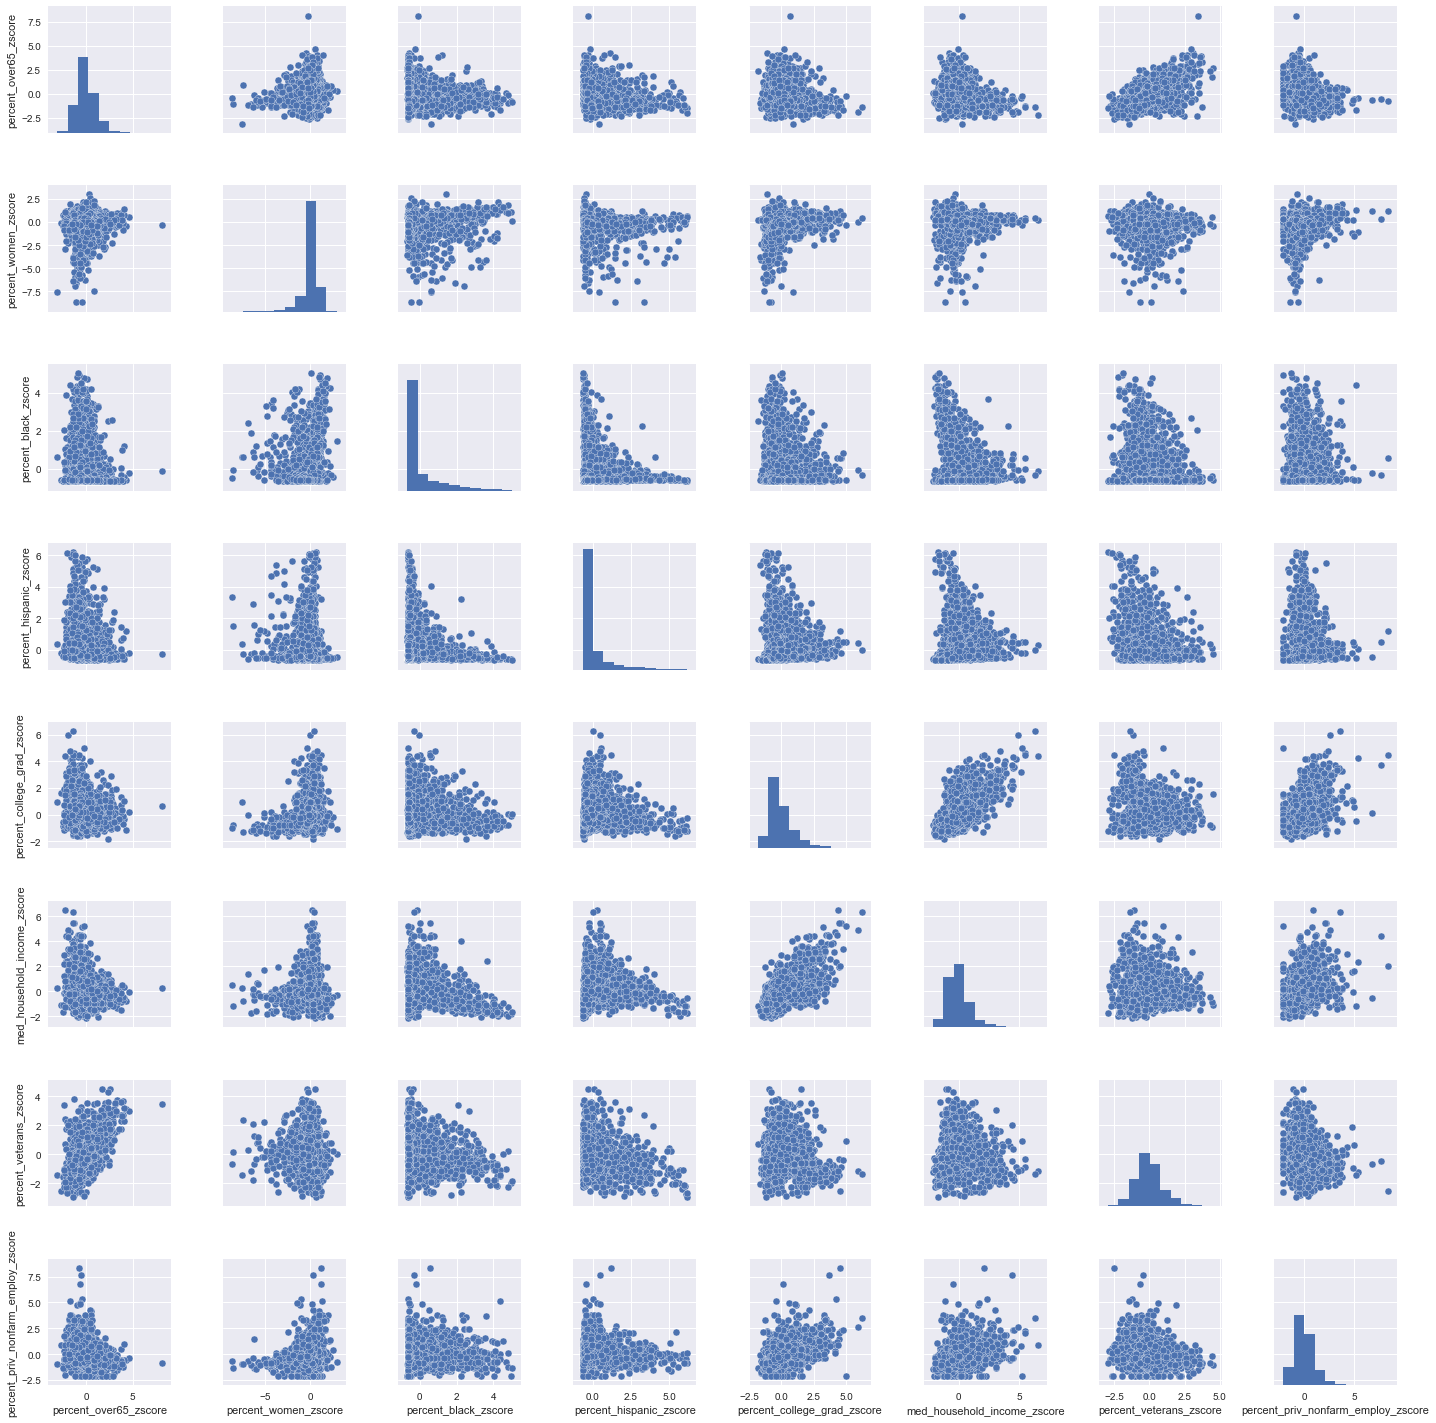

In [117]:
# Let's look at a pairplot in order to see the relationships between the different variables:
# Is there multicoliniarity?
sns.pairplot(Clinton_to_analyze,vars=['percent_over65_zscore','percent_women_zscore','percent_black_zscore',
                                     'percent_hispanic_zscore','percent_college_grad_zscore', 
                                     'med_household_income_zscore','percent_veterans_zscore',
                                     'percent_priv_nonfarm_employ_zscore'])
sns.plt.show()

In [118]:
#Run OLS regression for Sanders with standarized values:
Sanders_results_standard = smf.ols(formula="fraction_votes_zscore ~ percent_over65_zscore + \
                        percent_women_zscore + percent_black_zscore + \
                        percent_hispanic_zscore + percent_college_grad_zscore + \
                        med_household_income_zscore + percent_veterans_zscore + \
                        percent_priv_nonfarm_employ_zscore", 
                        data=Sanders_to_analyze).fit()

In [119]:
print(Sanders_results_standard.summary())

                              OLS Regression Results                             
Dep. Variable:     fraction_votes_zscore   R-squared:                       0.583
Model:                               OLS   Adj. R-squared:                  0.582
Method:                    Least Squares   F-statistic:                     489.8
Date:                   Tue, 04 Apr 2017   Prob (F-statistic):               0.00
Time:                           09:57:41   Log-Likelihood:                -2756.5
No. Observations:                   2809   AIC:                             5531.
Df Residuals:                       2800   BIC:                             5585.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [120]:
#Significant predictors in determining proportion of votes for Sanders:
# (Seems like everything??)
#% Age > 65- negative
#% Women - negative
#% Black- negative
#% Hispanic- negative
#% College grad- positive
# med_household_income - negative
#% veterans- positive
#
# If we examine the coefficients, it appears that percent_black and percent_college_grad are the two factors
# that have the greatest effect 
#
# Jargue-Bera test is very significant: errors are not normally distributed-- a problem. Get rid of outliers

In [121]:
#Run OLS regression for Trump with standarized values:
Trump_results_standard = smf.ols(formula="fraction_votes_zscore ~ percent_over65_zscore + \
                        percent_women_zscore + percent_black_zscore + \
                        percent_hispanic_zscore + percent_college_grad_zscore + \
                        med_household_income_zscore + percent_veterans_zscore + \
                        percent_priv_nonfarm_employ_zscore", 
                        data=Trump_to_analyze).fit()

In [122]:
print(Trump_results_standard.summary())

                              OLS Regression Results                             
Dep. Variable:     fraction_votes_zscore   R-squared:                       0.069
Model:                               OLS   Adj. R-squared:                  0.067
Method:                    Least Squares   F-statistic:                     25.29
Date:                   Tue, 04 Apr 2017   Prob (F-statistic):           6.14e-38
Time:                           09:57:41   Log-Likelihood:                -3764.5
No. Observations:                   2722   AIC:                             7547.
Df Residuals:                       2713   BIC:                             7600.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [123]:
#NOTE: R^2 is EXTREMELY SMALL! So interpret results carefully!
#
#Significant predictors in determining proportion of votes for Trump:
# 
#% Age > 65- positive
#% Hispanic- negative
#% veterans- positive
#% priv_nonfarm_employ- negative
#
# If we examine the coefficients, it appears that percent_over65 is the factor with the 
# greatest effect 
#
# Jargue-Bera test is very significant: errors are not normally distributed-- a problem. Get rid of outliers

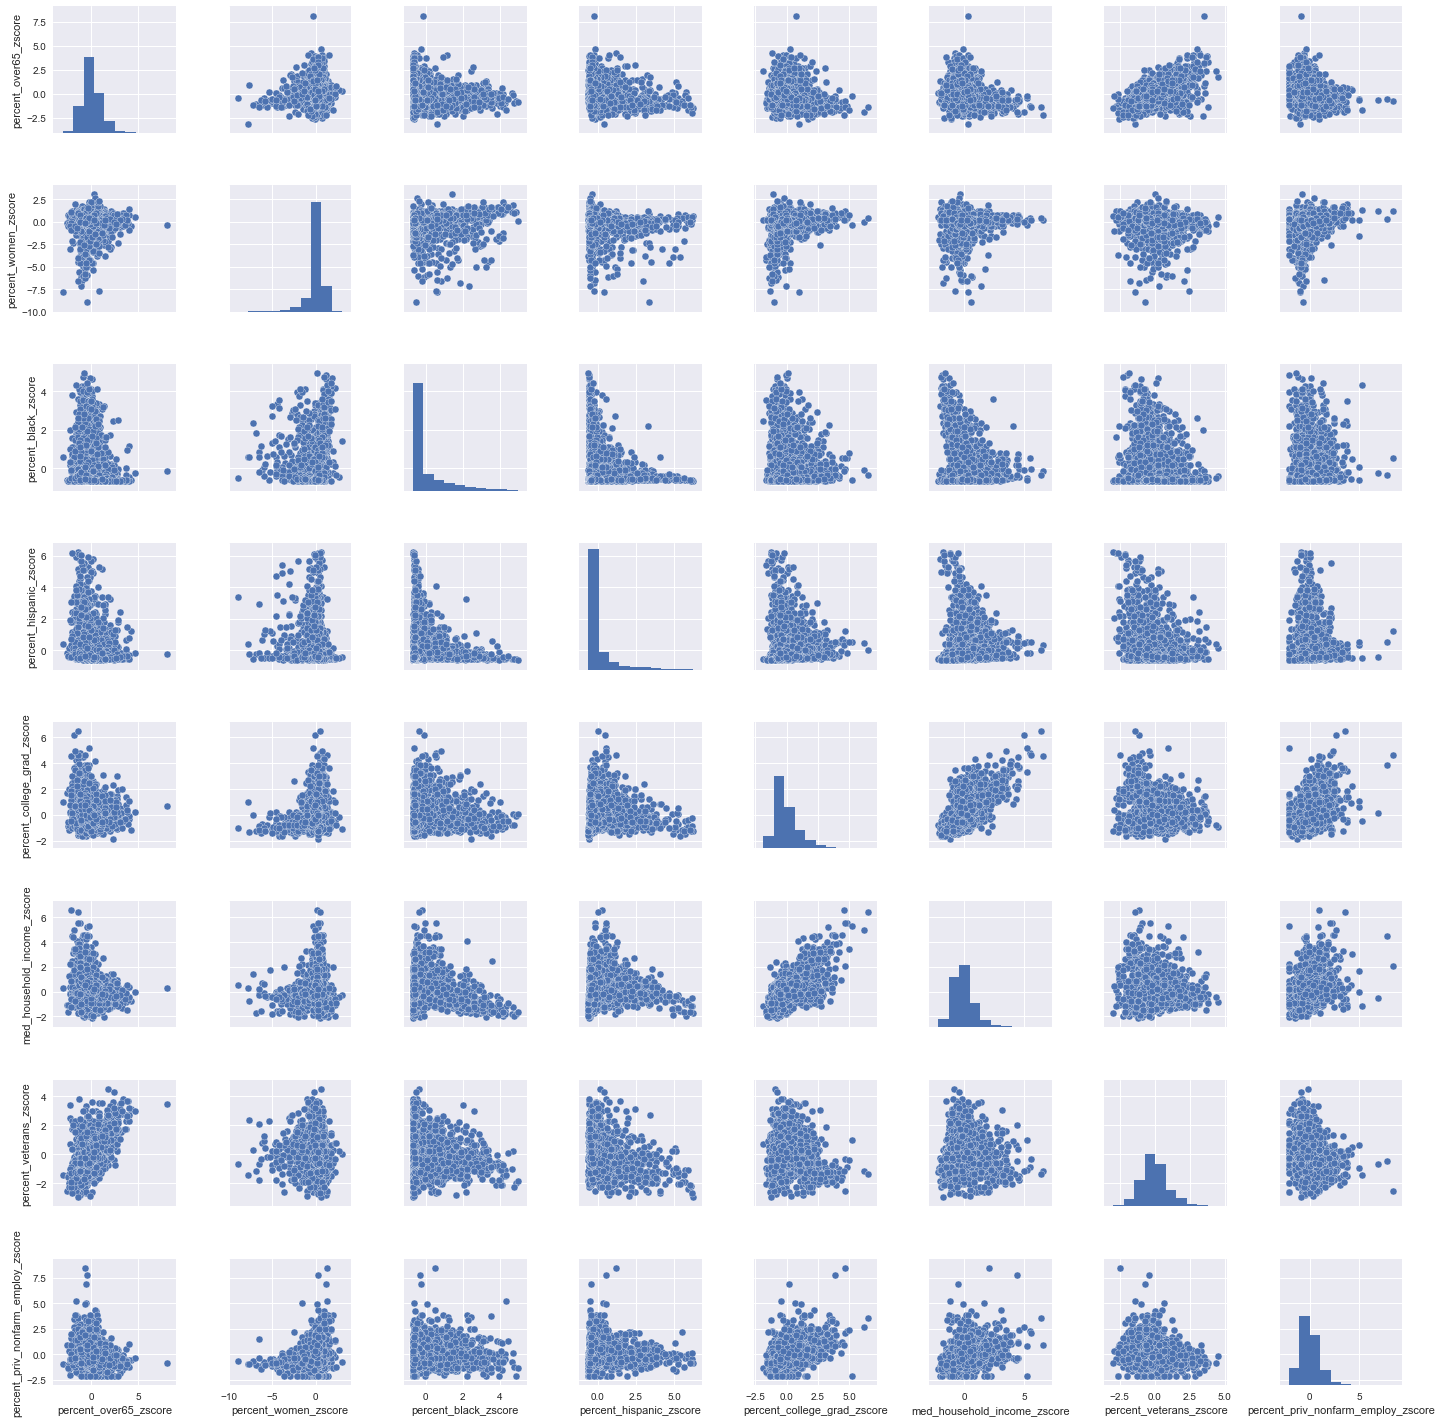

In [124]:
# Let's look at a pairplot in order to see the relationships between the different variables:
# Is there multicoliniarity?
sns.pairplot(Trump_to_analyze,vars=['percent_over65_zscore','percent_women_zscore','percent_black_zscore',
                                     'percent_hispanic_zscore','percent_college_grad_zscore', 
                                     'med_household_income_zscore','percent_veterans_zscore',
                                     'percent_priv_nonfarm_employ_zscore'])
sns.plt.show()

In [125]:
#Run OLS regression for Cruz with standarized values:
Cruz_results_standard = smf.ols(formula="fraction_votes_zscore ~ percent_over65_zscore + \
                        percent_women_zscore + percent_black_zscore + \
                        percent_hispanic_zscore + percent_college_grad_zscore + \
                        med_household_income_zscore + percent_veterans_zscore + \
                        percent_priv_nonfarm_employ_zscore", 
                        data=Cruz_to_analyze).fit()

In [126]:
print(Cruz_results_standard.summary())

                              OLS Regression Results                             
Dep. Variable:     fraction_votes_zscore   R-squared:                       0.092
Model:                               OLS   Adj. R-squared:                  0.089
Method:                    Least Squares   F-statistic:                     34.17
Date:                   Tue, 04 Apr 2017   Prob (F-statistic):           8.96e-52
Time:                           09:57:53   Log-Likelihood:                -3731.7
No. Observations:                   2722   AIC:                             7481.
Df Residuals:                       2713   BIC:                             7535.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [127]:
#NOTE: R^2 is EXTREMELY SMALL! So interpret results carefully!
#
#Significant predictors in determining proportion of votes for Cruz:
# 
#% Age > 65- negative
#% black - negative
#% Hispanic- positive
#% college grad- negative
#% veterans- negative
#
# If we examine the coefficients, it appears that percent_college_grad is the factor with the 
# greatest effect 
#
# Jargue-Bera test is very significant: errors are not normally distributed-- a problem. Get rid of outliers.

In [128]:
#Run OLS regression for Kasich with standarized values:
Kasich_results_standard = smf.ols(formula="fraction_votes_zscore ~ percent_over65_zscore + \
                        percent_women_zscore + percent_black_zscore + \
                        percent_hispanic_zscore + percent_college_grad_zscore + \
                        med_household_income_zscore + percent_veterans_zscore + \
                        percent_priv_nonfarm_employ_zscore", 
                        data=Kasich_to_analyze).fit()

In [129]:
print(Kasich_results_standard.summary())

                              OLS Regression Results                             
Dep. Variable:     fraction_votes_zscore   R-squared:                       0.198
Model:                               OLS   Adj. R-squared:                  0.196
Method:                    Least Squares   F-statistic:                     83.65
Date:                   Tue, 04 Apr 2017   Prob (F-statistic):          4.20e-124
Time:                           09:57:53   Log-Likelihood:                -3562.3
No. Observations:                   2722   AIC:                             7143.
Df Residuals:                       2713   BIC:                             7196.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [130]:
#NOTE: R^2 is EXTREMELY SMALL! So interpret results carefully!
#
#Significant predictors in determining proportion of votes for Cruz:
# 
#% black - negative
#% Hispanic- negative
#% college grad- positive
# med household income- positive
#% veterans- negative
#% priv_nonfarm_employ- positive 
#
# If we examine the coefficients, it appears that percent_hispanic & percent_college_grad are the factors with the 
# greatest effect 
#
# Jargue-Bera test is very significant: errors are not normally distributed-- a problem. Get rid of outliers. 